# Analyse multivariée: association, partitionnement et ordination

Pour cette section, vous aurez besoin que les modules suivants soient installés.


- [numpy](http://www.numpy.org). `conda install numpy` 
- [pandas](http://pandas.pydata.org). `conda install pandas` 
- [scipy](https://www.scipy.org/scipylib/index.html). `conda install scipy` 
- [matplotlib](http://matplotlib.org). `conda install matplotlib` 
- [seaborn](http://seaborn.pydata.org). `conda install seaborn` 
- [scikit-learn](http://scikit-learn.org/stable/). `conda install sklearn` 
- [scikit-bio](http://scikit-bio.org). `conda install skbio` (non disponible sur Windows) 
- [hdbscan](https://github.com/scikit-learn-contrib/hdbscan). `conda install -c conda-forge hdbscan`
- [scikit-plot](https://github.com/reiinakano/scikit-plot). `conda install -c conda-forge scikit-plot`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

## Espaces d'analyse

### Abondance et occurence

L'abondance est le décompte d'espèces observées, tandis que l'occurence est la présence ou l'absence d'une espèce. Le tableau suivant contient des données d'abondance.

In [2]:
abundance = pd.DataFrame({'Bruant familier': [1, 0, 0, 3],
                          'Citelle à poitrine rousse': [1, 0, 0, 0],
                          'Colibri à gorge rubis': [0, 1, 0, 0],
                          'Geai bleu': [3, 2, 0, 0],
                          'Bruant chanteur': [1, 0, 5, 2],
                          'Chardonneret': [0, 9, 6, 0],
                          'Bruant à gorge blanche': [1, 0, 0, 0],
                          'Mésange à tête noire': [20, 1, 1, 0],
                          'Jaseur boréal': [66, 0, 0, 0]},
                         index = ['Site 1', 'Site 2', 'Site 3', 'Site 4'])
abundance

,Bruant chanteur,Bruant familier,Bruant à gorge blanche,Chardonneret,Citelle à poitrine rousse,Colibri à gorge rubis,Geai bleu,Jaseur boréal,Mésange à tête noire
Site 1,1,1,1,0,1,0,3,66,20
Site 2,0,0,0,9,0,1,2,0,1
Site 3,5,0,0,6,0,0,0,0,1
Site 4,2,3,0,0,0,0,0,0,0


Ce tableau peut être rapidement transformé en données d'occurence, qui ne comprennent que l'information booléenne de présence (noté 1) et d'absence (noté 0).

In [3]:
occurence = (abundance > 0).astype(int)
occurence

,Bruant chanteur,Bruant familier,Bruant à gorge blanche,Chardonneret,Citelle à poitrine rousse,Colibri à gorge rubis,Geai bleu,Jaseur boréal,Mésange à tête noire
Site 1,1,1,1,0,1,0,1,1,1
Site 2,0,0,0,1,0,1,1,0,1
Site 3,1,0,0,1,0,0,0,0,1
Site 4,1,1,0,0,0,0,0,0,0


L'**espace des espèces** (ou des variables ou descripteurs) est celui où les espèces forment les axes et où les sites sont positionnés dans cet espace. Il s'agit d'une perspective en *mode R*, qui permet principalement d'identifier quels espèces se retrouvent plus courrament ensemble

Populating the interactive namespace from numpy and matplotlib


/home/essicolo/bin/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Text(0.5,0,'Chardonneret')

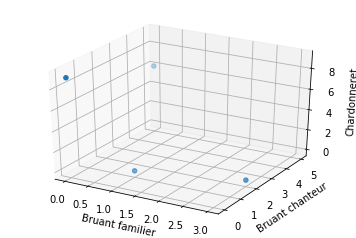

In [4]:
%pylab inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

species = ['Bruant familier', 'Bruant chanteur', 'Chardonneret']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(abundance[species[0]],
           abundance[species[1]],
           abundance[species[2]], marker='o')
ax.set_xlabel(species[0])
ax.set_ylabel(species[1])
ax.set_zlabel(species[2])

Dans l'**espace des sites** (ou les échantillons ou objets), on transpose la matrice d'abondance. On passe ici en *mode Q*, et l'on peut observer quels échantillons sont similaires.

Text(0.5,0,'Site 3')

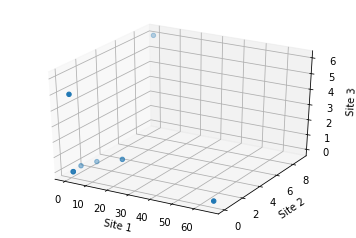

In [5]:
sites = abundance.index[0:3]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(abundance.T[sites[0]],
           abundance.T[sites[1]],
           abundance.T[sites[2]], marker='o')
ax.set_xlabel(sites[0])
ax.set_ylabel(sites[1])
ax.set_zlabel(sites[2])

### Environnement

L'**espace de l'environnement** comprend souvent un autre tableau contenant l'information sur l'environnement où se trouve les espèces: les coordonnées et l'élévation, la pente, le pH du sol, la pluviométrie, etc.

## Analyse d'association

Nous utiliserons le terme *association* come une **mesure pour quantifier la ressemblance ou la différence entre deux objets (échantillons) ou variables (descripteurs)**.

Alors que la corrélation et la covariance sont des mesures d'association entre des variables (analyse en *mode R*), la **similarité** et la **distance** sont deux types de une mesure d'association entre des objets (analyse en *mode Q*). Une distance de 0 est mesuré chez deux objets identiques. La distance augmente au fur et à mesure que les objets sont dissociés. Une similarité ayant une valeur de 0 indique aucune association, tandis qu'une valeur de 1 indique une association parfaite. À l'opposé, la dissimilarité est égale à 1-similarité.

La distance peut être liée à la similarité par la relation:

$$distance=\sqrt{1-similarité}$$

ou

$$distance=\sqrt{dissimilarité}$$

La racine carrée permet, pour certains indices de similarité, d'obtenir des propriétés euclédiennes. Pour plus de détails, voyez le tableau 7.2 de [Legendre et Legendre (2012)](https://www.elsevier.com/books/numerical-ecology/legendre/978-0-444-53868-0).

Les matrices d'association sont généralement présentées comme des matrices carrées, dont les dimensions sont égales au nombre d'objets (*mode Q*) ou de vrariables (*mode R*) dans le tableau. Chaque élément ("cellule") de la matrice est un indice d'association entre un objet (ou une variable) et un autre. Ainsi, la diagonale de la matrice est un vecteur nul (distance ou dissimilarité) ou unitaire (similarité), car elle correspond à l'association entre un objet et lui-même. 

Puisque l'association entre A et B est la même qu'entre B et A, et puisque la diagonale retourne une valeur convenue, il est possible d'exprimer une matrice d'association en mode "compact", sous forme de vecteur. Le vecteur d'association entre des objets A, B et C contiendra toute l'information nécessaire en un vecteur de trois chiffres, `[AB, AC, BC]`, plutôt qu'une matrice de dimension $3 \times 3$. L'impact sur la mémoire vive peut être considérable pour les calculs comprenant de nombreuses dimensions.

En Python, les calculs de similarité et de distances peuvent être effectués avec le module `scipy`. La fonction `pdist` permet de calculer les indices d'association en forme compact, que l'on peut étaler en forme carrée avec la fonction `squareform`.

Nous verons plus tard les méthodes de mesure de similarité et de distance plus loin. Pour l'instant, utilisons la méthode de *Jaccard* pour une démonstration sur des données d'occurence.

In [6]:
from scipy.spatial.distance import pdist, squareform
from sklearn import datasets

squareform(pdist(occurence, 'jaccard'))

array([[ 0.        ,  0.77777778,  0.75      ,  0.71428571],
       [ 0.77777778,  0.        ,  0.6       ,  1.        ],
       [ 0.75      ,  0.6       ,  0.        ,  0.75      ],
       [ 0.71428571,  1.        ,  0.75      ,  0.        ]])

Remarquez que `scipy` retourne une matrice dont la diagonale est de 0. La diagonale est l'association d'un objet avec lui-même. Or la similarité d'un objet avec lui-même devrait être de 1! En fait, par convention `scipy` retourne des dissimilarités, non pas des similarités. La matrice de distance serait donc calculée en extrayant la racine carrée des éléments de la matrice de dissimilarité:

In [7]:
dissimilarity = squareform(pdist(occurence, 'jaccard'))
distance = np.sqrt(dissimilarity)
distance

array([[ 0.        ,  0.8819171 ,  0.8660254 ,  0.84515425],
       [ 0.8819171 ,  0.        ,  0.77459667,  1.        ],
       [ 0.8660254 ,  0.77459667,  0.        ,  0.8660254 ],
       [ 0.84515425,  1.        ,  0.8660254 ,  0.        ]])

Dans le chapitre sur l'analyse compositionnelle, nous avons abordé les significations différentes que peuvent prendre le zéro. L'information fournie par un zéro peut être différente selon les circonstances. Dans le cas d'une variable continue, un zéro signifie généralement une mesure sous le seuil de détection. Deux tissus dont la concentration en cuivre est nulle ont une afinité sous la perspective de la concentration en cuivre. Dans le cas de mesures d'abondance (décompte) ou d'occurence (présence-absence), on pourra décrire comme similaires deux niches écologiques où l'on retrouve une espèce en particulier. Mais deux sites où l'on de retouve pas d'ours polaires ne correspondent pas nécessairement à des niches similaires! En effet, il peut exister de nombreuses raisons écologiques et méthodologiques pour lesquelles l'espèces ou les espèces n'ont pas été observées. C'est le problème des **double-zéros** (espèces non observées à deux sites), problème qui est amplifié avec les grilles comprenant des espèces rares.

La ressemblance entre des objets comprenant des données continues devrait être calculée grâce à des indicateurs *symétriques*. Inversement, les affinités entre les objets décrits par des données d'abondance ou d'occurence susceptibles de générer des problèmes de double-zéros devraient être évaluées grâce à des indicateurs *asymétriques*. Un défi supplémentaire arrive lorsque les données sont de type mixte.

Nous utiliserons la convention de `scipy` et nous calculerons la dissimilarité, non pas la similarité. Les mesures de dissimilarité sont calculées sur des données d'abondance ou des données d'occurence. Notons qu'il existe beaucoup de confusion dans la littérature sur la manière de nommer les dissimilarités (ce qui n'est pas le cas des distances, dont les noms sont reconnus). Dans les sections suivantes, nous noterons la dissimilarité avec un $d$ minuscule et la distance avec un $D$ majuscule.

### Association entre objets (mode Q)

#### Objets: Abondance

La **dissimilarité de Bray-Curtis** est asymétrique. Elle est aussi appelée l'indice de Steinhaus, de Czekanowski ou de Sørensen. Il est important de s'assurer de bien s'entendre la méthode à laquelle on fait référence. L'équation enlève toute ambiguité. La dissimilarité de Bray-Curtis entre les points A et B est calculée comme suit.

$$d_{AB} =  \frac {\sum \left| A_{i} - B_{i} \right| }{\sum \left(A_{i}+B_{i}\right)}$$

Utilisons `pdist` pour générer les vecteurs d'association, qui peuvent être transformés en matrices avec `squareform`. Le format "dictionnaire" de Python est pratique pour enregistrer la collection de vecteurs d'association que nous allons créer dans cette section.

In [8]:
associations_abund = {}
associations_abund['BrayCurtis'] = pdist(abundance, 'braycurtis')
squareform(associations_abund['BrayCurtis'])

array([[ 0.        ,  0.94339623,  0.96190476,  0.95918367],
       [ 0.94339623,  0.        ,  0.44      ,  1.        ],
       [ 0.96190476,  0.44      ,  0.        ,  0.76470588],
       [ 0.95918367,  1.        ,  0.76470588,  0.        ]])

La dissimilarité de Bray-Curtis est souvent utilisée dans la littérature. Toutefois, la version originale de Bray-Curtis n'est pas tout à fait métrique (semimétrique). Conséquemment, la **dissimilarité de Ruzicka** (une variante de la dissimilarité de Jaccard pour les données d'abondance) est métrique, et devrait probablement être préféré à Bary-Curtis ([Oksanen, 2006](http://ocw.um.es/ciencias/geobotanica/otros-recursos-1/documentos/vegantutorial.pdf)).

$$d_{AB, Ruzicka} =  \frac { 2 \times d_{AB, Bray-Curtis} }{1 + d_{AB, Bray-Curtis}}$$

In [9]:
associations_abund['Ruzicka'] = associations_abund['BrayCurtis'] * 2 / (1+associations_abund['BrayCurtis'])

La **dissimilarité de Kulczynski** (aussi écrit Kulsinski) est asymétrique et semimétrique, tout comme celle de Bray-Curtis. Elle est calculée comme suit.

$$d_{AB} = 1-\frac{1}{2} \times \left[ \frac{\sum min(A_i, B_i)}{\sum A_i} + \frac{\sum min(A_i, B_i)}{\sum B_i} \right]$$

La fonction `kulsinski` de la version de `scipy` 0.19.1 ne donne pas les résultats qu'elle devrait ([rapport de bogue](https://github.com/scipy/scipy/pull/3163#issuecomment-34224341)). Une fonction maison peut être conçue.

In [10]:
def kulczynski(X):
    d_AB = []
    for i in range(X.shape[0]):
        sum_i = X.iloc[i, :].sum()
        for j in range(X.shape[0]):
            if (i>j):
                df_ = X.iloc[[i, j], :]
                min_ = df_.apply(min, axis=0).sum()
                sum_j = X.iloc[j, :].sum()
                d_AB.append(1-0.5*(min_/sum_i + min_/sum_j))
    return(d_AB)

In [11]:
associations_abund['Kulczynski'] = kulczynski(abundance)

Une approche commune pour mesurer l'association entre sites décrits par des données d'abondance est la **distance de Hellinger**. Notez qu'il s'agit ici d'une distance, non pas d'une dissimilarité. La première étape est de diviser chaque donnée d'abondance par l'abondance totale pour chaque site, puis d'extraire la racine carrée de chaque élément. Enfin, on calcule la distance euclidienne entre chaque site. Pour rappel, une distance euclidienne est la généralisation en plusieurs dimensions du théorème de Pythagore, $c = \sqrt{a^2 + b^2}$.

$$D_{AB} = \sqrt {\sum \left( \frac{A_i}{\sum A_i} - \frac{B_i}{\sum B_i} \right)^2}$$

In [12]:
Hel_abundance = abundance.apply(lambda x: np.sqrt(x / np.sum(x)), axis=1) # prétraitement
associations_abund['Hellinger'] = pdist(Hel_abundance, 'euclidean')

Toute comme la distance d'Hellinger, la **distance de chord** est calculée par une distance euclidienne sur des données d'abondance transformées de sorte que chaque ligne ait une longueur (norme) de 1.

In [13]:
from sklearn.preprocessing import normalize
chord_abundance = normalize(abundance, axis=1)
associations_abund['chord'] = pdist(chord_abundance, 'euclidean')

La **métrique du chi-carré**, ou $\chi$-carré, ou chi-square, donne davantage de poids aux espèces rares qu'aux espèces communes. Son utilisation est recommandée lorsque les espèces rares sont de bons indicateurs de conditions écologiques particulières ([Legendre et Legendre, 2012](https://www.elsevier.com/books/numerical-ecology/legendre/978-0-444-53868-0), p. 308).

$$  d_{AB} = \sqrt{\sum _j \frac{1}{\sum y_j} \left( \frac{A_j}{\sum A} - \frac{B_j}{\sum B} \right)^2 }  $$

La métrique peut être transformée en distance en la multipliant par la racine carrée de la somme totale des espèces dans la matric d'abondance ($X$).

$$ D_{AB} = \sqrt{\sum X} \times d_{AB} $$

`scipy` n'offre pas les association du chi-carré dans sa trousse d'outil. Cette fonction fera le travail.

In [14]:
def chi_square(X, method='distance'):
    X = np.array(X)
    row_sums = X.sum(axis=1, keepdims=True)
    column_sums = X.sum(axis=0)
    scaled_X = X / (row_sums * np.sqrt(column_sums))
    if method == 'distance':
        D_AB = pdist(scaled_X, metric='euclidean') * np.sqrt(X.sum())
    elif method=='metric':
        D_AB = pdist(scaled_X, metric='euclidean')
    else:
        print('Wrong method')
    return(D_AB)

In [15]:
associations_abund['Chi-square'] = chi_square(abundance)

Une mannière visuellement plus intéressante de présenter une matrice d'association est un graphique de type *heatmap*, que le module `seaborn` permet de générer rapidement. Il est possible de générer ces graphiques dans une boucle.

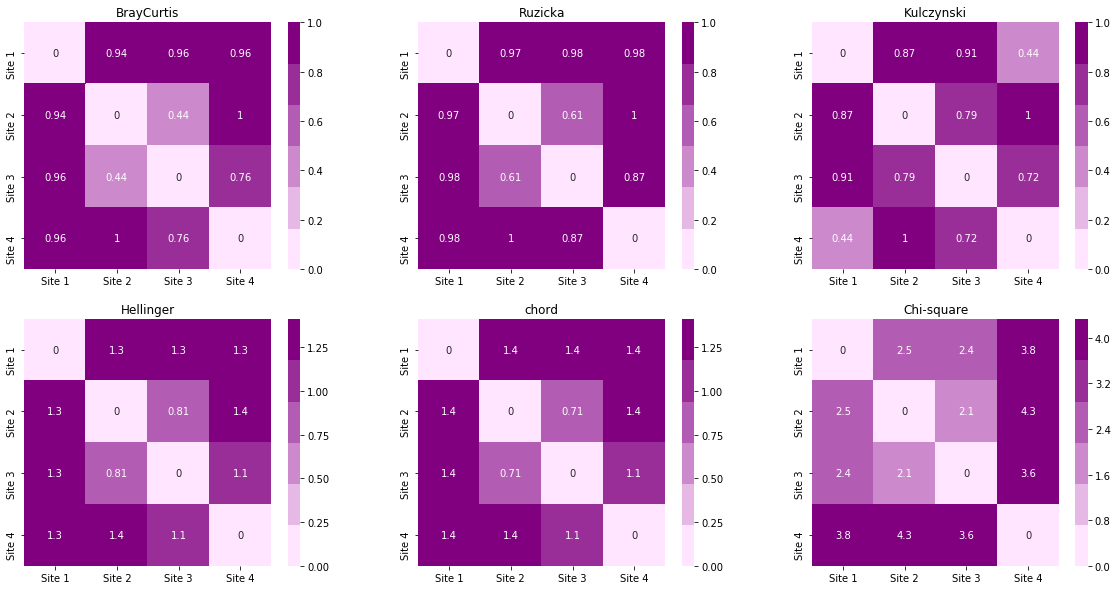

In [16]:
import seaborn as sns

plt.figure(figsize=(20, 10))
for i, key in enumerate(associations_abund):
    plt.subplot(2, 3, i+1)
    assoc_df = pd.DataFrame(squareform(associations_abund[key]), index=abundance.index, columns=abundance.index)
    sns.heatmap(assoc_df, annot=True, square=True, cmap=sns.light_palette("purple"))
    plt.title(key)

Peu importe le type d'association utilisée, les *heatmaps* montrent les mêmes tendances. Les assocaitions de dissimilarité (1ière ligne) s'étalent de 0 à 1, tandis que les distances (2ième ligne) partent de zéro, mais n'ont pas de limite supérieure. On note les plus grandes différences entre les sites 2 et 4, tandis que les sites 2 et 3 sont les plus semblables pour toutes les mesures d'association à l'exception de la dissimilarité de Kulczynski.

#### Objets: Occurence (présence-absence)

Des indices d'association différents devraient être utilisés lorsque des données sont compilées sous forme booléenne. En général, les tableaux de données d'occurence seront compilés avec des 1 (présence) et des 0 (absence).

La **similarité de Jaccard** entre le site A et le site B est la proportion de double 1 (présences de 1 dans A et B) parmi les espèces. La dissimilarié est la proportion complémentaire (comprenant [1, 0], [0, 1] et [0, 0]). La distance de Jaccard est la racine carrée de la dissimilarité.

In [17]:
associations_occ = {}
associations_occ['Jaccard'] = pdist(occurence, 'jaccard')

Les **distances d'Hellinger, de chord et de chi-carré** sont aussi appropriées pour les calculs de distances sur des tableaux d'occurence.

In [18]:
Hel_occurence = occurence.apply(lambda x: np.sqrt(x / np.sum(x)), axis=1)
associations_occ['Hellinger'] = pdist(Hel_occurence, 'euclidean')

Graphiquement,

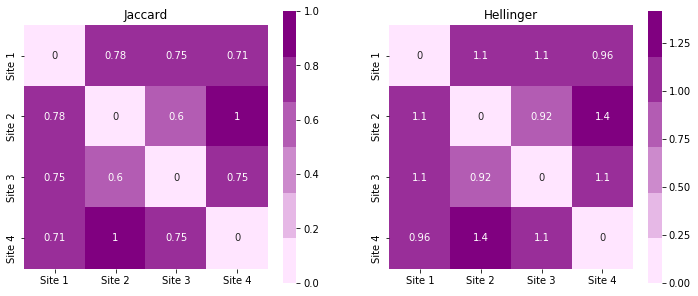

In [19]:
plt.figure(figsize=(12, 5))
for i, key in enumerate(associations_occ):
    plt.subplot(1, 2, i+1)
    assoc_df = pd.DataFrame(squareform(associations_occ[key]), index=occurence.index, columns=occurence.index)
    sns.heatmap(assoc_df, annot=True, square=True, cmap=sns.light_palette("purple"))
    plt.title(key)

Il est attendu que les matrices d'association sur l'occurence sont semblables à celles sur l'abondance. Dans ce cas-ci, la distance d'Hellinger donne des résultats semblables à la dissimilarité de Jaccard.

#### Objets: Données quantitatives

Les données quantitative en écologie peuvent décrire l'état de l'environnement: le climat, l'hydrologie, l'hydrogéochimie, la pédologie, etc. En règle générale, les coordonnées des sites ne sot pas des variables environnementales, à que l'on soupçonne la coordonnée elle-même d'être responsable d'effets sur notre système: mais il s'agira la plupart du temps d'effets confondants (par exemple, on peut mesurer un effet de lattitude sur le rendement des agrumes, mais il s'agira probablement avant tout d'effets dus aux conditions climatiques, qui elles changent en fonction de la lattitude). D'autre types de données quantitative pouvant être appréhendées par des distances sont les traits phénologiques, les ionomes, les génomes, etc.

La **distance euclidienne** est la racine carrée de la somme des carrés des distances sur tous les axes. Il s'agit d'une application multidimensionnelle du théorème de Pythagore. La **distance d'Aitchison**, couverte dans le chapitre 6, est une distance euclidienne calculée sur des données compositionnelles préalablement transformées. La distance euclidienne est sensible aux unités utilisés: utiliser des milimètres plutôt que des mètres enflera la distance euclidienne. Il est recommandé de porter une attention particulière aux unités, et de standardiser les données au besoin (par exemple, en centrant la moyenne à zéro et en fixant l'écart-type à 1).

On pourrait, par exemple, mesurer la distance entre des observations des dimensions de différentes espèces d'iris. Ce tableau est inclu dans le module graphique `seaborn`.

In [20]:
import seaborn as sns
iris = sns.load_dataset("iris")
iris.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,species
40,5.0,3.5,1.3,0.3,setosa
138,6.0,3.0,4.8,1.8,virginica
69,5.6,2.5,3.9,1.1,versicolor
146,6.3,2.5,5.0,1.9,virginica
54,6.5,2.8,4.6,1.5,versicolor


L'objet `iris` est un tableau pandas. Les mesures du tableau sont en centimètres. Pour éviter de donner davantage de poids aux longueur des sépales et en même temps de négliger la largeur des pétales, nous allons standardiser le tableau.

In [21]:
iris_features = iris.drop('species', axis=1)
iris_s = iris_features.apply(lambda x: (x-x.mean())/x.std(), axis=0)

La standadrisation semble correcte. Notez que la fonction `apply_along_axis` de `numpy` ressemble à fonction `.axis` de `pandas.DataFrame`, à l'exception de la manière de l'appeler, de l'ordre et du nom des arguments.

In [22]:
associations_cont = {}
associations_cont['euclidean'] = pdist(iris_s, 'euclidean')

La **distance de Mahalanobis** est semblable à la distance euclidienne, mais qui tient compte de la covariance de la matrice des objets. Cette covariance peut être utilisée pour décrire la structure d'un nuage de points. La figure suivante montre deux points verts qui se trouvent aux extrêmes d'un nuage de point. Ces points ont des distances euclidiennes par rapport au centre différentes: les lignes d'équidistance euclédienne sont tracées en rose. Toutefois, les deux points ont un distance de Mahalanobis égale à partir du centre.

<img src="images/image5.png" width=400>
<p style="text-align: center">Source: [Parent et al. (2012)](https://www.intechopen.com/books/soil-fertility/nutrient-balance-as-paradigm-of-plant-and-soil-chemometricsnutrient-balance-as-paradigm-of-soil-and-).</p>

La distance de Mahalanobis permet de représenter des distances dans un espace fortement corrélé. Elle est courramment utilisée pour détecter les valeurs aberrantes selon des critères de distance à partir du centre d'un jeu de données multivariées.

In [23]:
associations_cont['Mahalanobis'] = pdist(iris_features, 'mahalanobis')

La **distance de Manhattan** porte aussi le nom de distance de cityblock ou de taxi. C'est la distance que vous devrez parcourir pour vous rendre du point A au point B à Manhattan, c'est-à-dire selon une séquence de tronçons perpendiculaires.

$$ D_{AB} = \sum _i \left| A_i - B_i \right| $$

La distance de Manhattan est appropriée lorsque les gradients (changements d'un état à l'autre ou d'une région à l'autre) ne permettent pas des changements simultanés. Mieux vaut standardiser les variables pour éviter qu'une dimension soit prépondérante.

In [24]:
associations_cont['Manhattan'] = pdist(iris_s, 'cityblock')

Lors de la création du graphique, l'argument `annot=True` demande beaucoup de temps de calcul. La valeur par défaut étant `False`, on peut seulement retirer l'argument ou le spécifier explicitement.

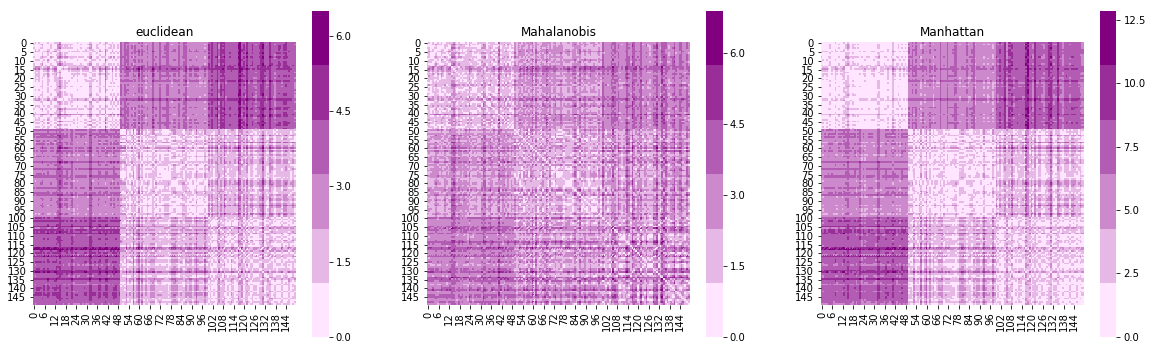

In [25]:
plt.figure(figsize=(20, 6))
for i, key in enumerate(associations_cont):
    plt.subplot(1, 3, i+1)
    assoc_df = pd.DataFrame(squareform(associations_cont[key]))
    sns.heatmap(assoc_df, annot=False, square=True, cmap=sns.light_palette("purple"))
    plt.title(key)

Le tableau `iris` est ordonné par espèce. Les distances euclidienne et deManhattan permettent aisément de distinguer les espèces selon les dimensions des pétales et des sépales. Toutefois, l'utilsation de la covariance avec la distance de Mahalanobis crée des distinction moins tranchées.

#### Objets: Données mixtes

Les données catégorielles ordinales peuvent être transformées en données continues par gradations linéaires ou quadratiques. Les données catégorielles nominales, quant à elles, peuvent être *dummyfiées* en données similaires à des occurences. Attention toutefois: contrairement à la régression linéaire qui demande d'exclure une catégorie, la *dummyfication* doit inclure toutes les catégories. Le comportement par défaut de la fonction `pandas.get_dummies` est de garder toutes les catégories. La **similarité de Gower** a été développée pour mesurer des associations entre des objets dont les données sont mixtes: booléennes, catégorielles et continues. La similarité de Gower est calculée en additionnant les distances calculées par colonne, individuellement. Si la colonne est booléenne, on utilise les distances de Jaccard (qui exclue les double-zéro) de manière univariée: une variable à la fois. Pour les variables continues, on utilise la distance de Manhattan divisée par la plage de valeurs de la variable (pour fin de standardisation). Puisqu'elle hérite de la particularité de la distance de Manhattan et de la similarité de Jaccard univariée, la **similarité de Gower** reste une combinaison linéaire de distances univariées.

In [26]:
# Notes
## possible avec ecopy, mais erreur. pull-request: https://github.com/Auerilas/ecopy/pulls
## possible avec scikit-learn: https://github.com/matchado/Misc/blob/master/gower_dist.py, mais jaccard non pas dice
## Attention: ça ne fonctionne pas bien. Changer la référence de dummification change la distance.
## Attendre la version de scikit-learn en développement: https://github.com/scikit-learn/scikit-learn/pull/9555

from sklearn.neighbors import DistanceMetric
def gower_distance(X):
    individual_variable_distances = []
    for i in range(X.shape[1]):
        feature = X.iloc[:,[i]]
        if feature.dtypes[0] == np.object:
            feature_dist = DistanceMetric.get_metric('jaccard').pairwise(feature)
        else:
            feature_dist = DistanceMetric.get_metric('manhattan').pairwise(feature) / np.ptp(feature.values)

        individual_variable_distances.append(feature_dist)

    return np.array(individual_variable_distances).mean(0)

Générons un jeu de données.

In [27]:
X = pd.DataFrame({'age':[21,21,19,30,21,21,19,30],
                'gender':['M','M','N','M','F','F','F','F'],
                'civil_status':['MARRIED','SINGLE','SINGLE','SINGLE','MARRIED','SINGLE','WIDOW','DIVORCED'],
                'salary':[3000.0,1200.0 ,32000.0,1800.0 ,2900.0 ,1100.0 ,10000.0,1500.0],
                'children':[True,False,True,True,True,False,False,True],
                'available_credit':[2200,100,22000,1100,2000,100,6000,2200]})

Il faut préalablement *dummifier* les variables catégorielles nominales.

In [28]:
X_dum = pd.get_dummies(X)
X_dum

,age,available_credit,children,salary,civil_status_DIVORCED,civil_status_MARRIED,civil_status_SINGLE,civil_status_WIDOW,gender_F,gender_M,gender_N
0,21,2200,True,3000.0,0,1,0,0,0,1,0
1,21,100,False,1200.0,0,0,1,0,0,1,0
2,19,22000,True,32000.0,0,0,1,0,0,0,1
3,30,1100,True,1800.0,0,0,1,0,0,1,0
4,21,2000,True,2900.0,0,1,0,0,1,0,0
5,21,100,False,1100.0,0,0,1,0,1,0,0
6,19,6000,False,10000.0,0,0,0,1,1,0,0
7,30,2200,True,1500.0,1,0,0,0,1,0,0


Calculons la dissimilarité de Gower.

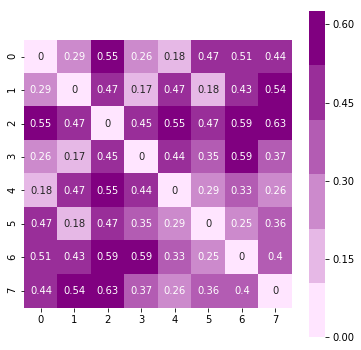

In [29]:
d_gow = gower_distance(X_dum)

plt.figure(figsize=(6, 6))
sns.heatmap(d_gow, square=True, annot=True, cmap=sns.light_palette("purple"))

Une avenue possible en mode multivarié est d'effectuer une moyenne (pondérée par une décision arbitraire) d'associations spécifiques.

### Associations entre variables (mode R)

Il existe de nombreuses approches pour mesurer les associations entre variables. La plus connue est la corrélation. Mais les données d'abondance et d'occurence demandent des approches différentes.

#### Variables: Abondance

La distance du chi-carré est suggérée par [Borcard et al. (2011)](http://www.springer.com/us/book/9781441979759).

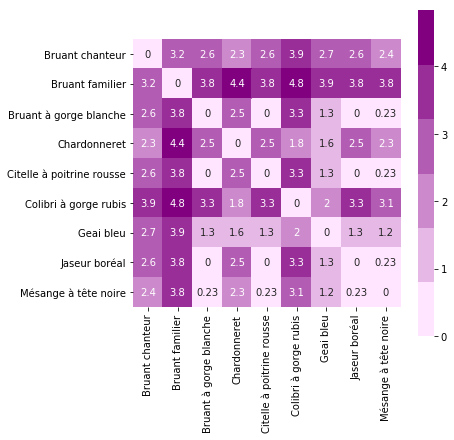

In [30]:
D_chisq_R = squareform(chi_square(abundance.T, method='distance'))
D_chisq_R_df = pd.DataFrame(D_chisq_R, 
                         columns=abundance.columns, 
                         index=abundance.columns)

plt.figure(figsize=(6, 6))
sns.heatmap(D_chisq_R_df, square=True, annot=True, cmap=sns.light_palette("purple"))

#### Variables: Occurence

La dissimilarité de Jaccard peut être utilisée.

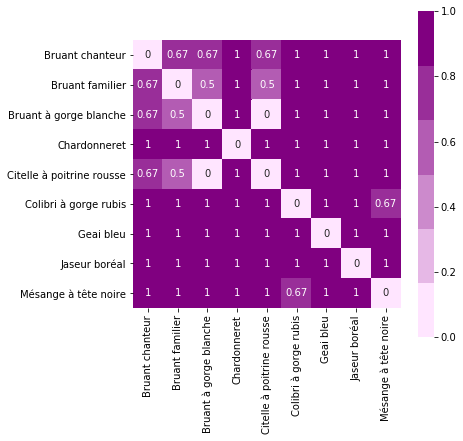

In [31]:
D_jacc_R = squareform(pdist(abundance.T, metric='jaccard'))
D_jacc_R_df = pd.DataFrame(D_jacc_R, 
                         columns=abundance.columns, 
                         index=abundance.columns)

plt.figure(figsize=(6, 6))
sns.heatmap(D_jacc_R_df, square=True, annot=True, cmap=sns.light_palette("purple"))

#### Variables: Quantités

La matrice des corrélations de Pearson peut être utilisée pour les données continues. Quant aux variables ordinales, elles devraient idéalement être liées linéairement ou quadratiquement. Si ce n'est pas le cas, c'est-à-dire que les catégories sont ordonnées par rang seulement, vous pourrez avoir recours aux coefficients de corrélation de Spearman ou de Kendall.

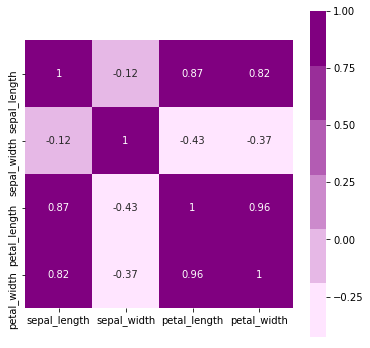

In [32]:
iris_cor = pd.DataFrame(np.corrcoef(iris_features.T),
                        columns = iris_features.columns, 
                        index = iris_features.columns)

plt.figure(figsize=(6, 6))
sns.heatmap(iris_cor, annot=True, square=True, cmap=sns.light_palette("purple"))

### Conclusion sur les associations

Il n'existe pas de règle claire pour déterminer quelle technique d'association utiliser. Cela dépend en premier lieu de vos données. Vous sélectionnerez votre méthode d'association selon le type de données que vous abordez, la question à laquelle vous désirez répondre ainsi l'expérience dans la littérature comme celle de vos collègues scientifiques. S'il n'existe pas de règle clair, c'est qu'il existe des dizaines de méthodes différentes, et la plupart d'entre elles vous donneront une perspective juste et valide. Il faut néanmoins faire attention pour éviter de sélectionner les méthodes qui ne sont pas appropriées. 

## Partitionnement

Les données suivantes ont été générées par [Leland McInnes](https://github.com/scikit-learn-contrib/hdbscan/blob/master/notebooks/clusterable_data.npy) (Tutte institute of mathematics, Ottawa). Êtes-vous en mesure d'identifier des groupes? Combien en trouvez-vous?

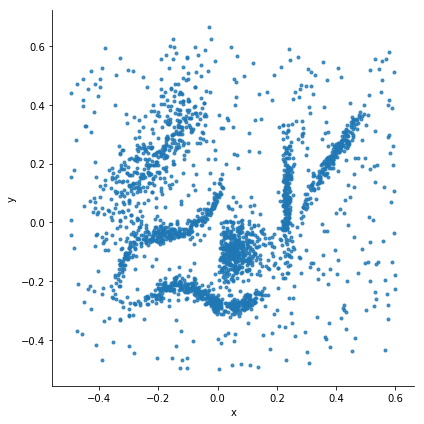

In [33]:
data_mcinnes = np.load('data/clusterable_data.npy')
df_mcinnes = pd.DataFrame({'x': data_mcinnes[:, 0],
                          'y': data_mcinnes[:, 1]})
plt.figure(figsize=(8, 8))
sns.lmplot('x', 'y', data=df_mcinnes, fit_reg=False, markers='.', size=6, aspect=1)

En 2D, l'oeil humain peut facilement détecter les groupes. En 3D, c'est toujours possible, mais au-delà de 3D, le partitionnement cognitive devient rapidement maladroite. Les algorithmes sont alors d'une aide précieuse. Mais ils transportent en pratique tout un baggage de limitations. Quel est le critère d'association entre les groupes? Combien de groupe devrions-nous créer? Comment distinguer une donnée trop bruitée pour être classifiée?

Le partitionnement de données (*clustering* en anglais), et inversement leur regroupement, permet de créer des ensembles selon des critères d'association. On suppose donc que Le partitionnement permet de créer des groupes selon l'information que l'on fait émerger des données. Il est conséquemment entendu que les données ne sont pas catégorisées à priori: **il ne s'agit pas de prédire la catégorie d'un objet, mais bien de créer des catégories à partir des objets** par exemple selon leurs dimensions, leurs couleurs, leurs signature chimique, leurs comportements, leurs gènes, etc. 

Plusieurs méthodes sont aujourd'hui offertes aux analystes pour partitionner leurs données. Dans le cadre de ce manuel, nous couvrirons ici deux grandes tendances dans les algorithmes.

1. *Méthodes hiérarchique et non hiérarchiques*. Dans un partitionnement hiérarchique, l'ensemble des objets forme un groupe, comprenant des sous-regroupements, des sous-sous-regroupements, etc., dont les objets forment l'ultime partitionnement. On pourra alors identifier comment se décline un partitionnement. À l'inverse, un partitionnement non-hiérarchique des algorhitmes permettent de créer les groupes non hiérarchisés les plus différents que possible.

2. *Membership exclusif ou flou*. Certaines techniques attribuent à chaque une classe unique: l'appartenance sera indiquée par un 1 et la non appartenance par un 0. D'autres techniques vont attribuer un membership flou où le degré d'appartenance est une variable continue de 0 à 1. Parmi les méthodes floues, on retrouve les méthodes probabilistes.

### Évaluation d'un partitionnement

Le choix d'une technique de partitionnement parmi de [nombreuses disponibles](http://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods), ainsi que le choix des paramètres gouvernant chacune d'entre elles, est avant tout basé sur ce que l'on désire définir comme étant un groupe, ainsi que la manière d'interpréter les groupes. En outre, **le nombre de groupe à départager est *toujours* une décision de l'analyste**. Néanmoins, on peut se fier [des indicateurs de performance de partitionnement](http://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation). Parmis ceux-ci, retenons le score [silouhette](http://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient) ainsi que l'[indice de Calinski-Harabaz](http://scikit-learn.org/stable/modules/clustering.html#calinski-harabaz-index).

#### Score silouhette

En anglais, le *h* dans silouhette se trouve après le *l*: on parle donc de *silhouette coefficient* pour désigner le score de chacun des objets dans le partitionnement. Pour chaque objet, on calcule la distance moyenne qui le sépare des autres points de son groupe ($a$) ainsi que la distance moyenne  qui le sépare des points du groupe le plus rapproché.

$$s = \frac{b-a}{max \left(a, b \right)}$$

Un coefficient de -1 indique le pire classement, tandis qu'un coefficient de 1 indique le meilleur classement. La moyenne des coefficients silouhette est le score silouhette.

#### Indice de Calinski-Harabaz

L'indice de Calinski-Harabaz est proportionnel au ratio des dispersions intra-groupe et la moyenne des dispersions inter-groupes. Plus l'indice est élevé, mieux les groupes sont définis. La mathématique est décrite [dans la documentation de scikit-learn](http://scikit-learn.org/stable/modules/clustering.html#calinski-harabaz-index).

**Note**. Les coefficients silouhette et l'indice de Calinski-Harabaz sont plus appropriés pour les formes de groupes convexes (cercles, sphères, hypersphères) que pour les formes irrégulières (notamment celles obtenues par la DBSCAN, discutée ci-desssous).

### Partitionnement non hiérarchique

Il peut arriver que vous n'ayez pas besoin de comprendre la structure d'agglomération des objets (ou variables).  Plusieurs techniques de partitionnement non hiérarchique [sont disponibles dans le module scikit-learn](http://scikit-learn.org/stable/modules/clustering.html). On s'intéressera en particulier à celles-ci.

**Kmeans** (`sklearn.cluster.Kmeans`). L'objectif des kmeans est de minimiser la distance euclédienne entre un nombre prédéfini de *k* groupes exclusifs.

1. L'algorhitme commence par placer une nombre *k* de centroides au hasard dans l'espace d'un nombre *p* de variables (vous devez fixer *k*, et *p* est le nombre de colonnes de vos données).
2. Ensuite, chaque objet est étiquetté comme appartenant au groupe du centroid le plus près.
3. La position du centroide est déplacée à la moyenne de chaque groupe.
4. Recommencer à partir de l'étape 2 jusqu'à ce que l'assignation des objets aux groupes ne change plus.

![](https://media.giphy.com/media/12vVAGkaqHUqCQ/giphy.gif)
<center>Source: [David Sheehan](https://dashee87.github.io/data%20science/general/Clustering-with-Scikit-with-GIFs/)</center>

La technique des kmeans suppose que les groupes ont des distributions multinormales - représentées par des cercles en 2D, des sphères en 3D, des hypersphères en plus de 3D. Cette limitation est problématique lorsque les groupes se présentent sous des formes irrégulières, comme celles du nuage de points de Leland McInnes, présenté plus haut. De plus, la technique classique des kmeans est basée sur des distances euclidiennes: l'utilisation des kmeans n'est appropriée pour les données comprenant beaucoup de zéros, comme les données d'abondance, qui devraient préalablement être transformées en variables centrées et réduites ([Legendre et Legendre, 2012](https://www.elsevier.com/books/numerical-ecology/legendre/978-0-444-53868-0)). La technique des **mixtures gaussiennes** (*gaussian mixtures*, `sklearn.mixture.GaussianMixture`) est une généralisation des kmeans permettant d'intégrer la covariance des groupes. Les groupes ne sont plus des hyper-sphères, mais des hyper-ellipsoïdes.

**DBSCAN** (`sklearn.cluster.DBSCAN`). La technique DBSCAN (* **D**ensity-**B**ased **S**patial **C**lustering of **A**pplications with **N**oise*) sousentend que les groupes sont composés de zones où l'on retrouve plus de points (zones denses) séparées par des zones de faible densité. Pour lancer l'algorithme, nous devons spécifier une mesure d'association critique (distance ou dissimilarité) *d* ainsi qu'un nombre de point critique *k* dans le voisinage de cette distance.

1. L'algorithme comme étiqueter chaque point selon l'une de ces catégories:

    - *Noyau*: le point a au moins *k* points dans son voisinage, c'est-à-dire à une distance inférieure ou égale à *d*.
    - *Bordure*: le point a moins de *k* points dans son voisinage, mais l'un de des points voisins est un *noyau*.
    - *Bruit*: le cas échéant. Ces points sont considérés comme des outliers.

    <img src="images/dbscan_1.svg" width=600>

2. Les noyaux distancés de *d* ou moins sont connectés entre eux en englobant les bordures.

    <img src="images/dbscan_2.svg" width=600>

Le nombre de groupes est prescrit par l'algorithme DBSCAN, qui permet du coup de détecter des données trop bruitées pour être classées.

[Damiani et al. (2014)](https://doi.org/10.1145/2666310.2666417) a développé une approche utilisant la technique DBSCAN pour partitionner des zones d'escale pour les flux de populations migratoires.

#### Application

Dans scikit-learn, on définit d'abord le modèle (par exemple `Kmeans(...)`), puis on l'applique à nos données (`fit(...)`), enfin on applique le modèle sur des données (`predict(...)`). Certaines fonctions utilisent toutefois le raccourcis `fit_predict`. Chaque algorithme doit être ajusté avec les paramètres qui convient. De nombreux paramètres par défaut sont utilisés dans les exécutions ci-dessous. Lors de travaux de recherche, l'utilsation d'un argument ou d'un autre dans une fonction doit être justifié: qu'un paramètre soit utilisé par défaut dans une fonction n'est a priori pas une justification convainquante.

Nous allons classifier les données de Leland McInnes, présentée ci-dessus. Importons les fonctions nécessaires.

In [34]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn import metrics

Pour les **kmeans**, on doit fixer le nombre de groupes. Le graphique des données de Leland McInnes montrent 6 groupes. Toutefois, il est rare que l'on puisse visualiser de telles démarquations, qui plus est dans des cas où l'on doit traiter de plus de deux dimensions. Je vais donc lancer le partitionnement en boucle pour plusieurs nombres de groupes, de 3 à 10 et pour chaque groupe, évaluer le score silouhette et de Calinski-Habaraz. J'utilise un argument `random_state` pour m'assurer que les groupes seront les mêmes à chaque fois que la cellule sera lancée.

Text(0,0.5,'Calinski-Harabaz index')

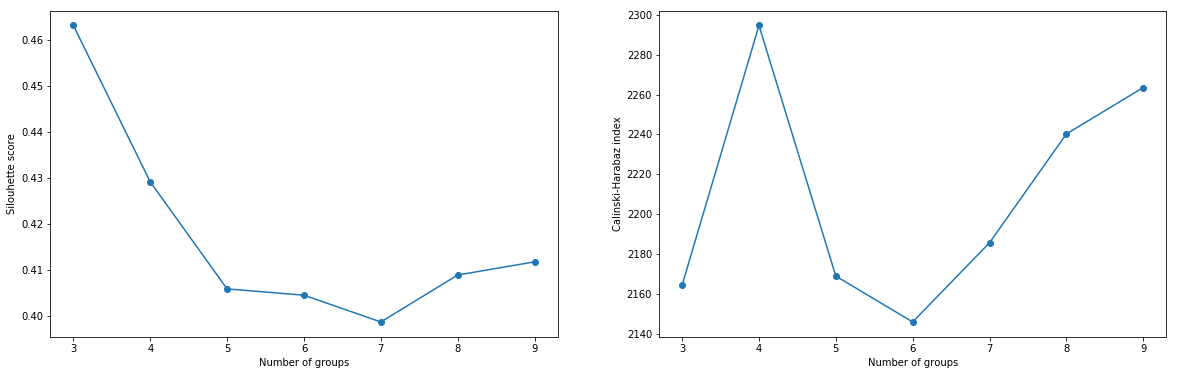

In [35]:
silouhette_score = []
calinski_index = []
n_groups = list(range(3, 10))
for i in n_groups:
    mcinnes_kmeans_labels = KMeans(n_clusters=i, random_state=5437925).fit_predict(data_mcinnes)
    silouhette_score.append(metrics.silhouette_score(data_mcinnes, mcinnes_kmeans_labels, 'euclidean'))
    calinski_index.append(metrics.calinski_harabaz_score(data_mcinnes, mcinnes_kmeans_labels))

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(n_groups, silouhette_score, '-o')
plt.xlabel('Number of groups')
plt.ylabel('Silouhette score')
plt.subplot(1, 2, 2)
plt.plot(n_groups, calinski_index, '-o')
plt.xlabel('Number of groups')
plt.ylabel('Calinski-Harabaz index')

La forme des groupes n'étant pas convexe, il fallait s'attendre à ce que indicateurs maximaux pour les deux indicateurs soient différents. C'est d'ailleurs souvent le cas. Cet exemple supporte que le choix du nombre de groupe à départager repose sur l'analyste, non pas uniquement sur les indicateurs de performance. Choisissons 6 groupes, puisque que c'est visuellement ce que l'on devrait chercher pour ce cas d'étude.

In [36]:
from scikitplot import clustering_factory

mcinnes_kmeans = clustering_factory(KMeans(n_clusters=6, random_state=5437925))
df_mcinnes['group_kmeans'] = mcinnes_kmeans.fit_predict(data_mcinnes)
print("Score silouhette:",
      metrics.silhouette_score(data_mcinnes, df_mcinnes['group_kmeans'], 'euclidean'))
print("Indice de Calinski-Habaraz:",
      metrics.calinski_harabaz_score(data_mcinnes, df_mcinnes['group_kmeans']))

/home/essicolo/bin/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function clustering_factory is deprecated; This will be removed in v0.4.0. The Factory API has been deprecated. Please migrate existing code into the various new modules of the Functions API. Please note that the interface of those functions will likely be different from that of the Factory API.
  warnings.warn(msg, category=DeprecationWarning)


Score silouhette: 0.404590768399
Indice de Calinski-Habaraz: 2146.05914177


Remarquez que la ligne `mcinnes_kmeans = ...` comprend la fonction `clustering_factory`. Cette fonction issue du module `scikit-plot` implémente `Kmeans` en lui dotant la possibilité de générer le graphique silouhette, qui présente les coefficients silouhette pour chacun des objets.

/home/essicolo/bin/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function plot_silhouette is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_silhouette instead.
  warnings.warn(msg, category=DeprecationWarning)


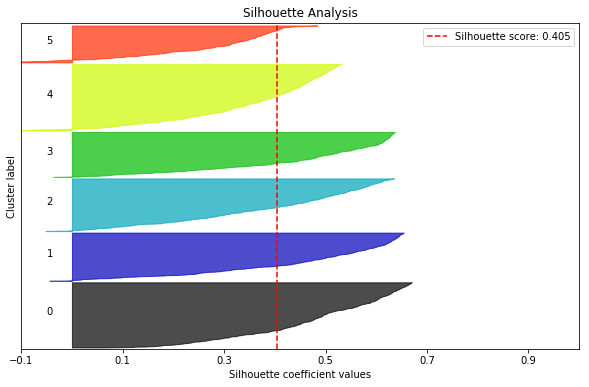

In [37]:
mcinnes_kmeans.plot_silhouette(data_mcinnes, figsize=(10, 6))

La technique **DBSCAN** n'est pas basée sur le nombre de groupe, mais sur la densité des points. Il est possible de spécifier le type d'association à utiliser dans l'argument `metric`, mais dans ce cas on doit se limiter aux [métriques offertes par scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html) (qui sont celles de scipy). Si la métrique souhaitée n'est pas disponible parmi celles-là, la matrice d'association peut être spécifiée dans l'argument `X` plutôt que les données directe quand l'argument `metric` est égal à `"precomputed"`. L'argument `min_samples` spécifie le nombre minimal de points qui l'on doit retrouver à une distance critique *d* pour la formation des *noyaux* et la propagation des groupes, spécifiée dans l'argument `eps`. La distance *d* peut être estimée en prenant une fraction de la moyenne, mais on aura volontiers recours à sont bon jugement.

In [38]:
mcinnes_dbscan_distmat = squareform(pdist(data_mcinnes, 'euclidean'))
mcinnes_dbscan = DBSCAN(metric='precomputed', min_samples=6, eps=0.026)
df_mcinnes['group_dbscan'] = mcinnes_dbscan.fit_predict(mcinnes_dbscan_distmat)
df_mcinnes['group_dbscan'].unique()

array([ 0, -1,  1,  2,  3,  4,  5,  6,  7])

Les paramètres spécifiés donnent 8 groupes (`0, 1, 2, ..., 7`) et des points trop bruités pour être classifiés (étiquetés `-1`). Voyons comment les groupes ont été formés.

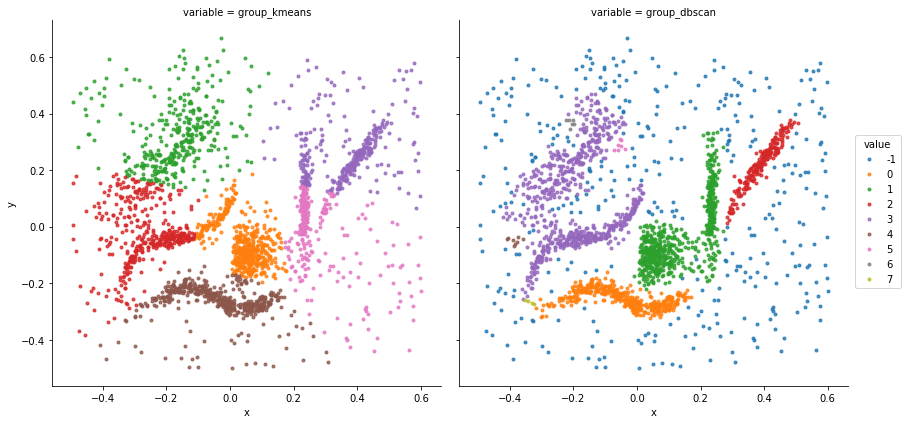

In [39]:
df_mcinnes_tidy = pd.melt(df_mcinnes, id_vars=['x', 'y'])
sns.lmplot('x', 'y', data=df_mcinnes_tidy, 
           fit_reg=False, 
           hue='value', markers='.', size=6, 
           aspect=1,
           col='variable')

L'algorithme kmeans est loin d'être statisfaisant. Cela est attendu, puisque les kmeans recherchent des distribution gaussiennes sur des groupes vraisemblablement non-gaussiens. Quant à DBSCAN, le partitionnement semble plus conforme à ce que l'on recherche. Néanmoins, DBSCAN cré quelques petits groupes indésirables ainsi que des grands groupes (violet et vert) qui auraient lieu d'être partitionnés.

### Partitionnement hiérarchique

Les techniques de partitionnement hiérarchique sont basées sur les matrices d'association. La technique pour mesurer l'association (entre objets ou variables) déterminera en grande partie le paritionnement des données. Les partitionnements hiérarchiques ont l'avantage de pouvoir être représentés sous forme de dendrogramme (ou arbre) de partition. Un tel dendrogramme présente des sous-groupes qui se joignent en groupes jusqu'à former un seul ensemble.

Le partitionnement hiérarchique est abondamment utilisé en phylogénie, pour étudier les relations de parenté entre organismes vivants, populations d'organismes et espèces. La phénétique, branche empirique de la phylogénèse interspécifique, fait usage du partitionnement hiérarchique à partir d'associations génétiques entre unités taxonomiques. On retrouve de nombreuses ressources académiques en phylogénétique ainsi que des outils pour [Python](https://academic.oup.com/bioinformatics/article/26/12/1569/287181/DendroPy-a-Python-library-for-phylogenetic) et [R](https://www.springer.com/us/book/9781461495413). Toutefois, la phylogénétique en particulier ne fait pas partie de la présente ittération de ce manuel.

#### Techniques de partitionnement hiérarchique

Le partitionnement hiérarchique est typiquement effectué avec une des quatres méthodes suivantes, dont chacune possède ses particularités, mais sont toutes agglomératives: à chaque étape d'agglomération, on fusionne les deux groupes ayant le plus d'affinité sur la base des deux sous-groupes les plus rapprochés.

**Single link** (`single`). Les groupes sont agglomérés sur la base des deux points parmi les groupes, qui sont les plus proches.

**Complete link** (`complete`). À la différence de la méthode *single*, on considère comme critère d'agglomération les éléments les plus éloignés de chaque groupe.

**Agglomération centrale**. Il s'agit d'une fammille de méthode basées sur les différences entre les tendances centrales des objets ou des groupes.

- **Average** (`average`). Appelée UPGMA (Unweighted Pair-Group Method unsing Average), les groupes sont agglomérés selon un centre calculés par la moyenne et le nombre d'objet pondère l'agglomération (le poids des groupes est retiré). Cette technique est historiquement utilisée en bioinformatique pour partitionner des groupes phylogénétiques ([Sneath et Sokal, 1973](https://www.cabdirect.org/cabdirect/abstract/19730310919)).
- **Weighted** (`weighted`). La version de average, mais non pondérée (WPGMA).
- **Centroid** (`centroid`). Tout comme average, mais le centroïde (centre géométrique) est utilisé au lieu de la moyenne. Accronyme: UPGMC.
- **Median** (`median`). Appelée WPGMC. Devinez! ;)

**Ward** (`ward`). L'optimisation vise à minimiser les sommes des carrés par regroupement.

#### Quel outil de partitionnement hiérarchique utiliser?

Alors que le choix de la matrice d'association dépend des données et de leur contexte, la technique de partitionnement hiérarchique peut, quant à elle, être basée sur un critère numérique. Il en existe plusieurs, mais le critère recommandé pour le choix d'une technique de partitionnement hiérarchique est la **corrélation cophénétique**. La distance cophénétique est la distance à laquelle deux objets ou deux sous-groupes deviennent membres d'un même groupe. La corrélation cophénétique est la corrélation de Pearson entre le vecteur d'association des objets et le vecteur de distances cophénétiques.

#### Application

Les techniques de partitionnement hiérarchique présentées ci-dessus, ainsi que la fonction `cophenet` pour calculer la corrélation cophénétique, sont disponibles dans `scipy.cluster.hierarchy`. Nous allons classifier les dimensions des iris grâce à la distance de Manhattan.

In [40]:
mcinnes_hclust_distmat = pdist(data_mcinnes, 'euclidean')

In [41]:
from scipy.cluster.hierarchy import *

clustering_methods = ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']
clust_l = []
coph_corr_l = []
for i in range(len(clustering_methods)):
    clust_m = linkage(y=mcinnes_hclust_distmat, method=clustering_methods[i])
    clust_l.append(clust_m)
    coph_corr_l.append(cophenet(clust_m, mcinnes_hclust_distmat)[0])

# créer un dictionnaire avec les listes
clust_d = dict(zip(clustering_methods, clust_l))
coph_corr_d = dict(zip(clustering_methods, coph_corr_l))

# créer un tableau grâce au dictionnaire
coph_corr_df = pd.DataFrame(coph_corr_d, index=[0]).melt()
coph_corr_df

,variable,value
0,average,0.697121
1,centroid,0.713944
2,complete,0.534390
3,median,0.516069
4,single,0.486935
5,ward,0.584880
6,weighted,0.557286


La méthode `centroid` retourne la corrélation la plus élevée. Pour cet exemple, nous utiliserons `average` afin de faciliter l'intégration avec scikit-learn, qui ne comprend pas dans sa version actuelle le partitionnement par centroid dans ses fonctions. Pour plus de flexibilité, enchâssons le nom de la méthode dans une variable. Ainsi, en chageant le nom de cette variable, le reste du code sera conséquent.

In [42]:
best_method = 'average'

Le partitionnement hiérarchique peut être visualisé par un dendrogramme.

Text(0,0.5,'Height')

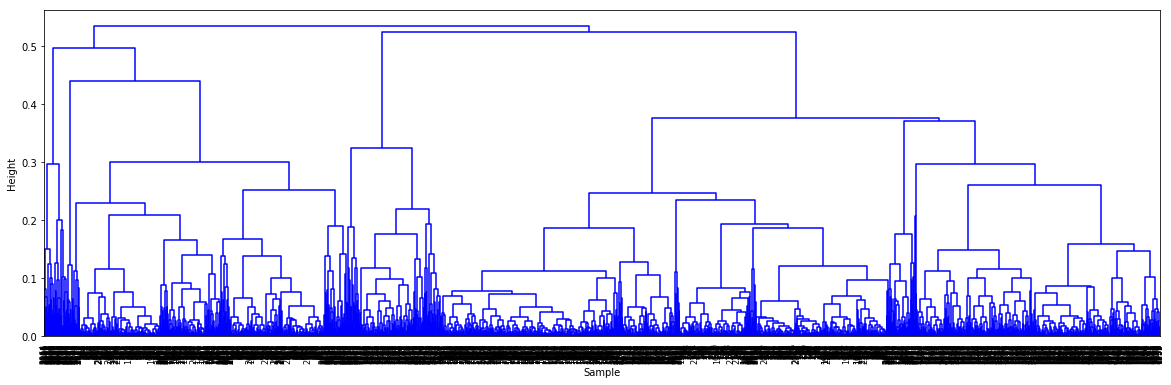

In [43]:
plt.figure(figsize=(20, 6))
dnd = dendrogram(clust_d[best_method], color_threshold=0, leaf_font_size=8)
plt.xlabel('Sample')
plt.ylabel('Height')

#### Combien de groupes utiliser?

La longueur des lignes verticales est la distance séparant les groupes enfants. Bien que la sélection du nombre de groupe soit avant tout basée sur les besoins du problème, nous pouvons nous appuyer sur certains outils. La hauteur totale peut servir de critère pour définir un nombre de groupes adéquat. On pourra sélectionner le nombre de groupe où la hauteur se stabilise en fonction du nombre de groupe. On pourra aussi utiliser le *graphique silhouette*, comprenant une collection de *largeurs de silouhette*, représentant le degré d'appartenance à son groupe. La fonction `sklearn.metrics.silhouette_score`, du module scikit-learn, s'en occupe.

In [44]:
nodes_f = fcluster(Z=clust_d[best_method], t=2, criterion='maxclust')
np.unique(nodes_f)

array([1, 2], dtype=int32)

In [45]:
from sklearn import metrics

# hauteur
heights = clust_d[best_method][:, 2]

# silouhette
silouhette = []
max_clus = 15
n_clust = list(range(3, max_clus))
for i in n_clust:
    nodes_f = fcluster(Z=clust_d[best_method], t=i, criterion='maxclust')
    silouhette.append(metrics.silhouette_score(data_mcinnes, nodes_f, metric='euclidean'))

# nombre de groupes correspondant à la largeur de silhouette maximale
n_clust_smax = np.array(n_clust)[silouhette == np.max(silouhette)]
silouhette_smax = np.array(silouhette)[silouhette == np.max(silouhette)]

In [46]:
n_clust_smax

array([14])

La largeur de silhouette maximale est atteinte à seulement deux groupes. Sur graphique,

(0, 15)

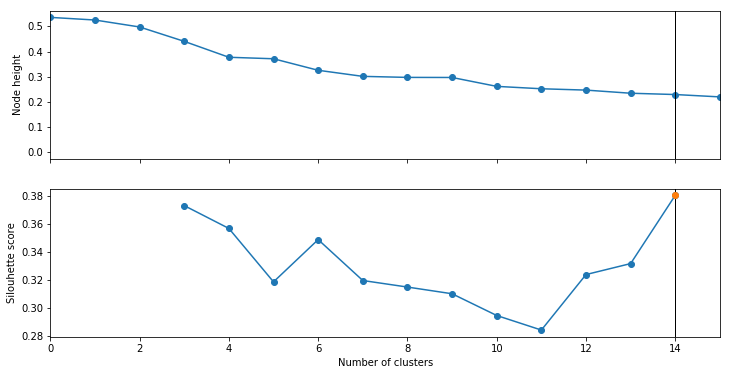

In [47]:
f, ax = plt.subplots(2, sharex=True, figsize=(12, 6))

ax[0].plot(list(range(len(heights)))[::-1], heights, '-o')
ax[0].set_ylabel('Node height')
ax[0].axvline(x=n_clust_smax, c='k', linewidth=1)

ax[1].plot(n_clust, silouhette, '-o')
ax[1].axvline(x=n_clust_smax, c='k', linewidth=1)
ax[1].plot(n_clust_smax, silouhette_smax, 'o')
ax[1].set_xlabel('Number of clusters')
ax[1].set_ylabel('Silouhette score')
ax[1].set_xlim([0, max_clus])

Un nombre élevé de groupe pourrait être créés. Mais puisque nous pouvons discerner 6 groupes dans les données, retenons 6 groupes, coupés à une hauteur entre 0.35 et 0.40 sur le dendrogramme.

Text(0,0.5,'Hauteur')

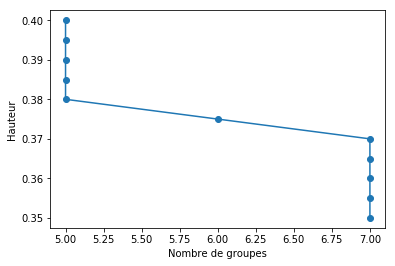

In [48]:
heights_test = np.arange(0.35, 0.40, 0.005)
n_groups = []
for i in heights_test:
    nodes_f = fcluster(Z=clust_d[best_method], t=i, criterion='distance')
    n_groups.append(len(np.unique(nodes_f)))
plt.plot(n_groups, heights_test, '-o')
plt.xlabel('Nombre de groupes')
plt.ylabel('Hauteur')

Il n'y a qu'une seule valeur de distance calculé pouvant générer 6 groupes.

In [49]:
heights_test[np.array(n_groups)==6][0]

0.375

Coupons le dendrorgamme à cette hauteur.

Text(0,0.5,'Height')

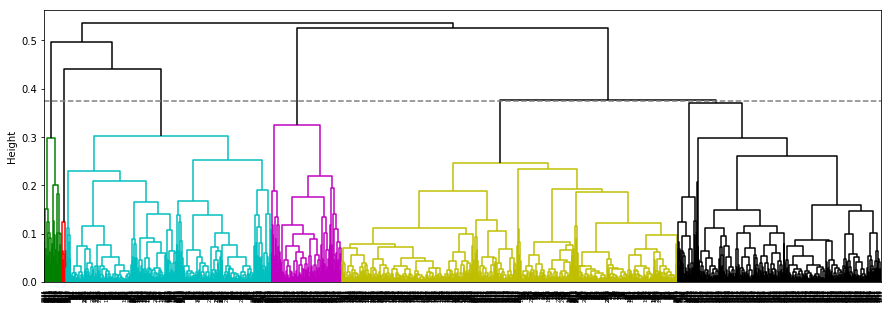

In [50]:
cut_off = heights_test[np.array(n_groups)==6][0]
plt.figure(figsize=(15, 5))
dendrogram(clust_d[best_method], leaf_rotation=90, color_threshold=cut_off,
          above_threshold_color='black')
plt.axhline(y=cut_off, c='grey', linestyle='dashed')
plt.ylabel('Height')

On voit clairement qu'un le cluster comporte peu de données. On fera intervenir scikit-learn pour créer un graphique silouhette.

/home/essicolo/bin/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function clustering_factory is deprecated; This will be removed in v0.4.0. The Factory API has been deprecated. Please migrate existing code into the various new modules of the Functions API. Please note that the interface of those functions will likely be different from that of the Factory API.
  warnings.warn(msg, category=DeprecationWarning)
/home/essicolo/bin/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function plot_silhouette is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_silhouette instead.
  warnings.warn(msg, category=DeprecationWarning)


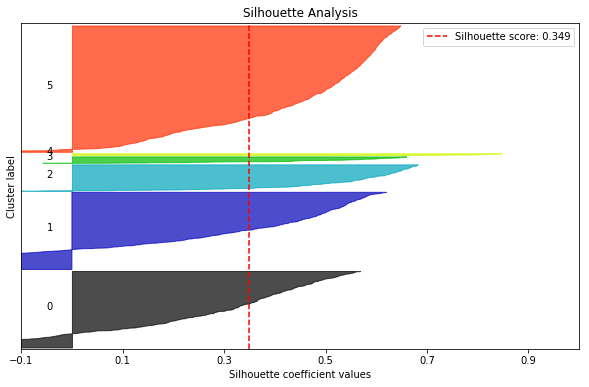

In [51]:
from sklearn.cluster import AgglomerativeClustering
mcinnes_hclust_sk = clustering_factory(AgglomerativeClustering(n_clusters=6, affinity='euclidean',
                                                               linkage='average').fit(data_mcinnes))
mcinnes_hclust_sk.plot_silhouette(data_mcinnes, figsize=(10, 6))

Les groupes 3 et 4 comportent peut d'objets. Les groupes 0 et 1 comportent un bon nombre d'objets apparamment mal classés.

Une autre forme de représentation de le partitionnement hiérarchique est le *clustermap*, qui présente le partitionnement ainsi que la matrice de données.

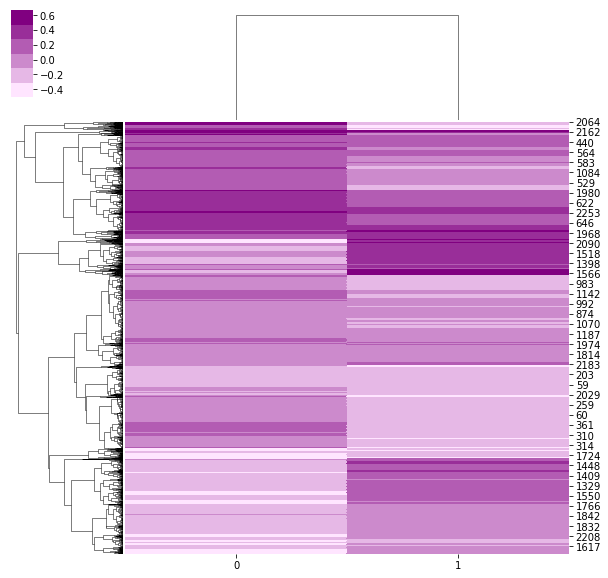

In [52]:
sns.clustermap(data_mcinnes, metric='euclidean', method=best_method, cmap=sns.light_palette("purple"))

Intégrons nos résultats dans le tableau.

In [53]:
df_mcinnes['group_hclust'] = fcluster(Z=clust_d[best_method], t=6, criterion='maxclust')

### Partitionnement hiérarchique basée sur la densité des points
La tecchinque HDBSCAN, dont l'algorithme est relativement récent ([Campello et al., 2013](https://link.springer.com/chapter/10.1007%2F978-3-642-37456-2_14)), permet une partitionnement hiérarchique sur le même principe des zones de densité de la technique DBSCAN. Le HDBSCAN a été utilisée pour partitionner les lieux d'escale d'oiseaux migrateurs en Chine ([Xu et al., 2013](https://www.jstage.jst.go.jp/article/dsj/12/0/12_WDS-027/_article)).

Avec DBSCAN, un rayon est fixé dans une métrique appropriée. Pour chaque point, on compte le nombre de point voisins, c'est à dire le nombre de point se situant à une distance (ou une dissimilarité) égale ou inférieure au rayon fixé. Avec HDBSCAN, on spécifie le nombre de points devant être recouverts et on calcule le rayon nécessaire pour les recouvrir. Ainsi, chaque point est associé à un rayon critique que l'on nommera $d_{noyau}$. La métrique initiale est ensuite altérée: on remplace les associations entre deux objets A et B par la valeur maximale entre cette association, le rayon critique de A et le rayon critique de B. Cette nouvelle distance est appelée la *distance d'atteinte mutuelle*: elle accentue les distances pour les points se trouvant dans des zones peu denses. On applique par la suite un algorithme semblable à la partition hiérarchique *single link*: En s'élargissant, les rayons se superposent, chaque superposition de rayon forment graduellement des groupes qui s'agglomèrent ainsi de manière hiérarchique. Au lieu d'effectuer une tranche à une hauteur donnée dans un dendrogramme de partitionnement, la technique HDBSCAN se base sur un dendrogramme condensé qui discarte les sous-groupes comprenant moins de *n* objets ($n_{gr min}$). Dans nouveau dendrogramme, on recherche des groupes qui occupent bien l'espace d'analyse. Pour ce faitre, on utilise l'inverse de la distance pour créer un indicateur de *persistance* (semblable à la similarité), $\lambda$. Pour chaque groupe hiérarchique dans le dendrogramme condensé, on peut calculer la persistance où le groupe prend naissance. De plus, pour chaque objet d'un groupe, on peut aussi calculer une distance à laquelle il quitte le groupe. La *stabilité* d'un groupe est la domme des différences de persistance entre la persistance à la naissance et les persistances des objets. On descend dans le dendrogramme. Si la somme des stabilité des groupes enfants est plus grande que la stabilité du groupe parent, on accepte la division. Sinon, le parent forme le groupe. La [documentation du module `hdbscan`](http://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html) pour Python offre une description intuitive et plus exhaustive des principes et algorithme de HDBSCAN.

#### Paramètres

Outre la métrique d'association dont nous avons discuté, HDBSCAN demande d'être nourri avec [quelques paramètres importants](http://hdbscan.readthedocs.io/en/latest/parameter_selection.html). En particulier, le **nombre minimum d'objets par groupe**, $n_{gr min}$ (ou `min_cluster_size` dans le module `hdbscan`) dépend de la quantité de données que vous avez à votre disposition, ainsi que de la quantité d'objets que vous jugez suffisante pour créer des groupes. Ce paramètre a évedemment une influence sur le nombre de groupes formés, mais aussi sur la quantité de valeurs aberrantes détectées. Un autre paramètre important est le **nombre de points devant être recouverts**, $k$ (`min_samples` dans `hdbscan`). Plus $k$ est élevé, plus la densité nécessaire pour créer un groupe sera élevée et plus HDBSCAN désignera de points somme du bruit. Parmi les **algorithmes de sélection des groupes** du module `hdbscan`, on retrouve l'*excess of mass* (`cluster_selection_method='eom'`, par défaut) qui a tendance à créer des groupes de tailles différentes, et *leaf* (`cluster_selection_method='leaf'`) qui permet de créer des groupes comprenant des quantités d'objets plus homogènes.

#### Application

Utilisons le module `hdbscan` ainsi que les données de Leland McInnes. La métrique utilisée sera euclidienne. Les métriques disponibles sont [celles de scikit-learn](http://hdbscan.readthedocs.io/en/latest/basic_hdbscan.html). Il est néamoins possible d'utiliser une métrique personalisée (Gower, par exemple) en utilisant la matrice d'association en guise de données et en spécifiant `metric='precomputed'`.

In [54]:
import hdbscan
hdbscan_clust = hdbscan.HDBSCAN(min_cluster_size=20, # le nombre de point minimum par groupe
                                min_samples=5, # le nombre de points dans le voisinage pour calculer le "rayon noyau"
                                metric='euclidean', 
                                gen_min_span_tree=True)
hdbscan_clust.fit(data_mcinnes)
df_mcinnes['group_hdbscan'] = hdbscan_clust.labels_

Demandons les valeurs uniques de la nouvelle colonne `group_hdbscan` de notre tableau pour obtenir le nombre de groupes calculés.

In [55]:
df_mcinnes['group_hdbscan'].unique()

array([ 1, -1,  2,  0,  3,  5,  4])

Nous avons 6 groupes, numérotés de 0 à 5, ainsi que des étiquettes identifiant des objets désignés comme étant du bruit de fond, numéroté -1. Le dendrogramme non condensé peu être produit.

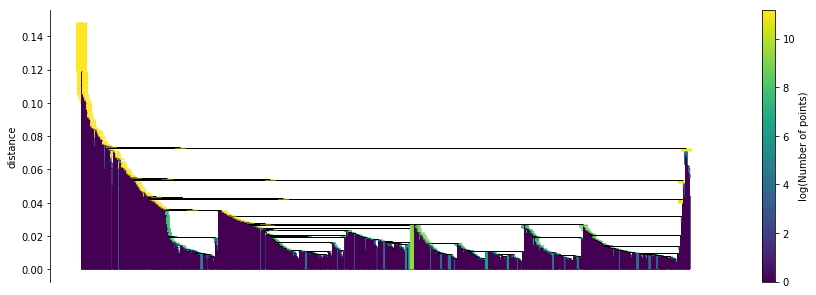

In [56]:
plt.figure(figsize=(15, 5))
hdbscan_clust.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

Difficile d'y voir clair avec autant d'objets. L'obnjet `hdbscan_clust` a un nombre minimum d'objets par groupe de 20. Ce qui permet de présenter le dendrogramme de manière condensée.

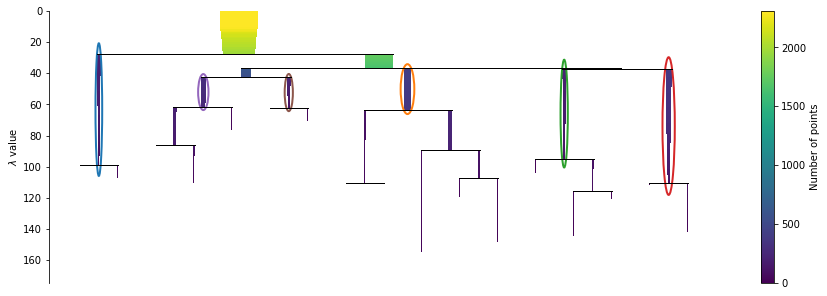

In [57]:
plt.figure(figsize=(15, 5))
hdbscan_clust.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

Enfin, un aperçu des stratégies de partitionnement utilisés jusqu'ici.

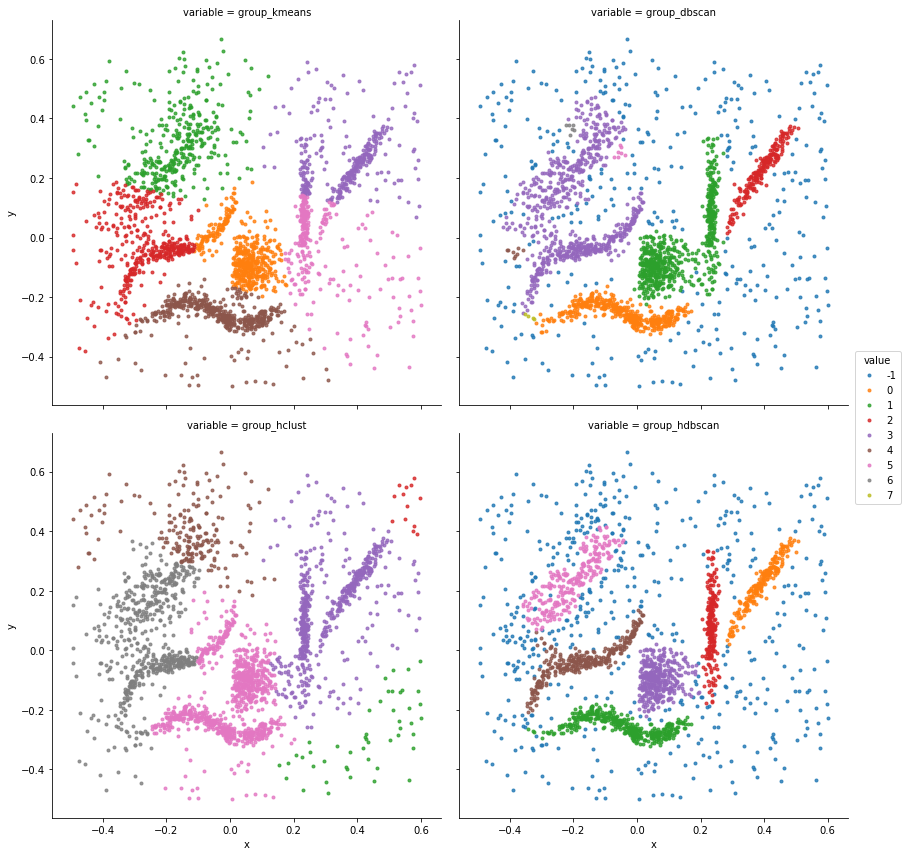

In [58]:
df_mcinnes_tidy = pd.melt(df_mcinnes, id_vars=['x', 'y'])
sns.lmplot('x', 'y', data=df_mcinnes_tidy, 
           fit_reg=False, 
           hue='value', markers='.', size=6, 
           aspect=1,
           col='variable', col_wrap=2)

Clairement, le partitionnement avec HDBSCAN donne les meilleurs résultats.

### Conclusion sur le partitionnement

Au chapitre 4, nous avons vu avec le jeu de données "datasaurus" que la visualisation peut permettre de détecter des structures en segmentant les données selon des groupes.

<img src="images/datasaurus_mix.png" width=400>

<img src="images/datasaurus_facet.png">

Or, si les données n'étaient pas étiquetées, leur structure serait indétectable avec les algorithmes disponibles actuellement. Le partitionnement permet d'explorer des données, de détecter des tendances et de dégager des groupes permettant la prise de décision.

Plusieurs techniques de partitionnement ont été présentées. Le choix de la technique sera déterminante sur la manière dont les groupes seront partitionnés. La définition d'un groupe variant d'un cas à l'autre, il n'existe pas de règle pour prescrire une méthode ou une autre. La partitionnement hiérarchique a l'avantage de permetre de visualiser comment les groupes s'agglomèrent. Parmi les méthodes de partitionnement hiérarchique disponibles, les méthodes basées sur la densité permettent une grande flexibilité, ainsi qu'une détection d'observations ne faisant partie d'aucun goupe.

## Ordination

En écologie, biologie, agronommie comme en foresterie, la plupart des tableaux de données comprennent de nombreuses variables: pH, nutriments, climat, espèces ou cultivars, etc. L'ordination vise à mettre de l'ordre dans des données dont le nombre élevé de variables peut amener à des difficultés d'appréciation et d'interprétaion ([Legendre et Legendre, 2012](https://www.elsevier.com/books/numerical-ecology/legendre/978-0-444-53868-0)). Plus précisément, le terme ordination est utilisé en écologie pour désigner les techniques de réduction d'axe. L'analyse en composante principale est probablement la plus connue de ces techniques. Mais de nombreuses techniques d'ordination ont été développées au cours des dernières années, chacune ayant ses domaines d'application.

Les techniques de réduction d'axe permettent de dégager l'information la plus importante en projetant une synthèse des relations entre les observations et entre les variables. Les techniques ne supposant aucune structure *a priori* sont dites *non-contraignantes*: elles ne comprennent pas de tests statistiques. À l'inverse, les ordinations contraignantes lient des variables descriptives avec une ou plusieurs variables prédictives.

La référence en la matière est indiscutablement ([Legendre et Legendre, 2012](https://www.elsevier.com/books/numerical-ecology/legendre/978-0-444-53868-0)). Cette section en couvrira quelques unes et vous guidera vers la technique la plus appropriée pour vos données.

### Ordination non contraignante

Cette section couvrira l'**analyse en composantes principales** (ACP), l'**analyse de correspondance** (AC), **l'analyse factorielle** (AF) ainsi que l'**analyse en coordonnées principales** (ACoP).

| Méthode | Distance préservée | Variables |
|---|---|---|
| Analyse en composantes principales (ACP) | Distance euclidienne | Données quantitatives, relations linéaires (attention aux double-zéros) |
| Analyse de correspondance (AC) | Distance de $\chi^2$ | Données non-négatives, dimentionnellement homogènes ou binaires, abondance ou occurence |
| Positionnement multidimensionnel (PoMd) | Toute mesure de dissimilarité | Données quantitatives, qualitatives nominales/ordinales ou mixtes |

Source: Adapté de ([Legendre et Legendre, 2012](https://www.elsevier.com/books/numerical-ecology/legendre/978-0-444-53868-0), chapitre 9)


Ces techniques 

#### Analyse en composantes principales

L'objectif d'une ACP est de représenter les données dans un nombre réduit de dimensions représentant le plus possible la variation d'un tableau de données: elle permet de projetter les données dans un espace où les variables sont combinées en axes orthogonaux dont le premier axe capte le maximum de variance. L'ACP peut par exemple être utilisée pour analyser des corrélations entre variables ou dégager l'information la plus pertinente d'un tableau de données météo ou de signal en un nombre plus retreint de variables.

L'ACP effectue est une rotation des axes à partir du centre (moyenne) du nuage de points effectuée de manière à ce que le premier axe définisse la direction où l'on retrouve la variance maximale. Ce premier axe est une combinaison linéaire des variables et forme la première composante principale. Une fois cet axe définit, on trouve de deuxième axe, orthogonal au premier, où l'on retouve la variance maximale - cet axe forme la deuxième composante principale, et ainsi de suite jusqu'à ce que le nombre d'axe corresponde au nombre de variables. Les projections des observations sur ces axes principaux sont appelés les **scores**. Les projections des variables sur les axes principaux sont les **vecteurs propres**  (*eigenvectors*, ou *loadings*). La variance des composantes principales diminue de la première à la dernière, et peut être calculée comme une proportion de la variance totale: c'est le **pourcentage d'inertie**. Par convention, on utilise les **valeurs propres** (*eigenvalues*) pour mesurer l'importance des axes. Si la première composante principale a une inertie de 50% et la deuxième a une intertie de 30%, la représentation en 2D des projection représentera 80% de la variance du nuage de points.

L'hétérogénéité des échelles de mesure peut avoir une grande importance sur les résultats d'une ACP (les données doivent être dimensionnellement homogènes). En effet, la hauteur d'un ceriser aura une variance plus grande que le diamètre d'une cerise exprimé dans les mêmes unités, et cette dernière aura plus de variance que la teneur en cuivre d'une feuille. Il est conséquemment avisé de mettre les données à l'échelle en centrant la moyenne à zéro et l'écart-type à 1 avant de procéder à une ACP.

L'ACP a été conçue pour projetter en un nombre moindre de dimensions des observations dont les distributions sont multinormales. Bien que l'ACP soit une technique robuste, il est préférable de transformer préalablement les variables dont la distribution est particulièrement asymétriques ([Legendre et Legendre, 2012, p. 450](https://www.elsevier.com/books/numerical-ecology/legendre/978-0-444-53868-0)). Le cas échéant, les valeurs extrêmes pourraient faire dévier les vecteurs propres et biaiser l'analyse. En particulier, les données ACP menées sur des données compositionnelles sont réputées pour générer des analyses biaisées ([Pawlowsky-Glahn and Egozcue, 2006](http://sp.lyellcollection.org/content/specpubgsl/264/1/1.full.pdf)). Le test de Mardia ([Korkmaz, 2014](https://journal.r-project.org/archive/2014-2/korkmaz-goksuluk-zararsiz.pdf)) peut être utilisé pour tester la multinormalité. Une distribution multinormale devrait générer des scores en forme d'hypersphère (en forme de cercle sur un biplot: voir plus loin).

##### Vecteurs propres et valeurs propres

Une matrice carrée (comme une matrice de covariance $\Sigma$) multipliée par un vecteur propre $e$ est égale aux valeurs propres $\lambda$ multipliées par les vecteurs propres $e$.

$$ \Sigma e = \lambda e $$

De manière intuitive, les vecteurs propres indiquent l'orientation de la covariance, et les valeurs propres indique la longueur associée à cette direction. L'ACP est basée sur le calcul des vecteurs propres et des valeurs propres de la matrice de covariance des variables. Pour d'abord obtenir les valeurs propres $\lambda$, il faut résoudre l'équation

$$ det(cov(X) - \lambda I) = 0 $$, 

où $det$ est l'opération permettant de calculer le déterminant, $cov$ est l'opération pour calculer la covariance, $X$ est la matrice de données, $\lambda$ sont les valeurs propres et $I$ est une matrice d'identité.

Pour $p$ variables dans votre tableau $X$, vous obtiendrex $p$ valeurs propres. Ensuite, on trouve les vecteurs propres en résolvant l'équation $ \Sigma e = \lambda e $.

Bien qu'il soit possible d'[effectuer cette opération à la main](https://www.youtube.com/watch?v=2fCBE7DWgd0&list=PLBv09BD7ez_5_yapAg86Od6JeeypkS4YM) pour des cas très simples, vous aurez avantage à utiliser un langage de programmation.

Chargeons les données d'iris du module scikit-learn, puis isolons seulement les deux premières colonnes (dimensions des sépales) l'espèce *setosa* (target de 0).

In [59]:
import seaborn as sns
iris = sns.load_dataset("iris")
setosa_sepal = iris.loc[iris.species=='setosa', 
                        ['sepal_length', 'sepal_width']]

Pour tester la multinormalité, utilisons l'algorithme `mardia_test` incluse dans le fichier `mardia.py` inclus dans le dossier `lib` du dossier hôte de ce document.

In [60]:
from lib.mardia import mardia_test
mardia_test(setosa_sepal.as_matrix())

{'Chi small skew': 0.8379338883266616,
 'P-value kurtosis': 0.9255380819568686,
 'P-value skew': 0.94379324054474123,
 'P-value small': 0.93329136233952237,
 'Z kurtosis': 0.093460055361023808,
 'chi_skew': 0.75950352438043689,
 'g1p': 0.091140422925652428,
 'g2p': 8.1057379822653601}

Pour considérer la distribution comme multinormale, la p-value de la distortion (`P-value skew`) **et** la statistique de Kurtosis (`Z kurtosis`) doit être égale ou plus élevée que 0.05 ([Kormaz, 2017, fiche d'aide de la fonction mardiaTest de R](https://www.rdocumentation.org/packages/MVN/versions/4.0/topics/mardiaTest)). C'est bien le cas pour les données du tableau `setosa_sepal`.

Retirons de la matrice de covariance les valeurs et vecteurs propres avec la fonction `numpy.linalg.eig`. Cette fonction soutire une partie imaginaire dont nous pouvons nous débarrasser en les transformant en nombres réels avec `.astype(np.float)`.

In [61]:
eigen = np.linalg.eig(np.cov(setosa_sepal.T))
eigenvalues = eigen[0].astype(np.float)
eigenvectors = eigen[1].astype(np.float)

La matrice des vecteurs propres se lit plus aisément dans un tableau transposé, où `x` et `y` sont les coordonnées.

In [62]:
pd.DataFrame(eigenvectors, 
             index=['x', 'y'], 
             columns=['eigenvector 1', 'eigenvector 2']).T

,x,y
eigenvector 1,-0.740778,0.671750
eigenvector 2,-0.671750,-0.740778


Les vecteurs propres ont une longueur unitaire (norme de 1). Ils peuvent être mis à l'échelles à la racine carrée des valeurs propres. Pour effectuer une translation des vecteurs propres au centre du nuage de point, nous avons besoin du centroïde.

In [63]:
eigenscaled = eigenvectors.dot(np.diag(np.sqrt(eigenvalues)))
centroid = setosa_sepal.mean(axis=0)

Dans la cellule suivante, nous effectuons une translation des vecteurs propres (`eigX_loc)` et des vecteurs propres mis à l'échelle (`eigX_loc_sc`).

In [64]:
eig1_loc = np.array([centroid, centroid+eigenvectors[:,0]])
eig2_loc = np.array([centroid, centroid+eigenvectors[:,1]])
eig1_loc_sc = np.array([centroid, centroid+eigenscaled[:,0]])
eig2_loc_sc = np.array([centroid, centroid+eigenscaled[:,1]])

Puis nous les illustrons dans le nuage de points. Les vecteurs propres sont en vert et les vecteurs propres mis à l'échelle sont en rouge.

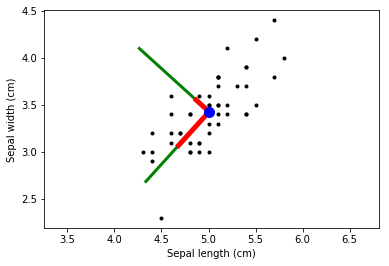

In [65]:
plt.plot(setosa_sepal.sepal_length, setosa_sepal.sepal_width, '.', c='k')
plt.plot(eig1_loc[:, 0], eig1_loc[:, 1], c='green', lw=3)
plt.plot(eig2_loc[:, 0], eig2_loc[:, 1], c='green', lw=3)
plt.plot(eig1_loc_sc[:, 0], eig1_loc_sc[:, 1], c='red', lw=5)
plt.plot(eig2_loc_sc[:, 0], eig2_loc_sc[:, 1], c='red', lw=5)
plt.plot(centroid[0], centroid[1], 'o', c='blue', ms=10)
plt.xlabel('Sepal length (cm)')
plt.ylabel('Sepal width (cm)')
plt.axis('equal');

On peut observer que, comme je l'ai mentionné plus haut, **les vecteurs propres indiquent l'orientation de la covariance, et les valeurs propres indique la longueur associée à cette direction**.

##### Biplot

Imaginez un nuage de points en 3D, axes y compris. Vous tournez votre nuage de points pour trouver la perspective en 2D qui fera en sorte que vos données soient les plus dispersées possibles. Avec une lampe de poche, vous illuminez votre nuage de points dans l'axe de cette perspective: vous venez d'effectuer une analyse en composantes principales, et l'ombre des points et des axes sur le mur formera votre biplot.

Pour créer un biplot, on juxtapose les descripteurs (variables) en tant que vecteurs propres, représentés par des flèches, et les objets (observations) en tant que scores, représentés par des points. Les résultats d'une ordination peuvent être présentés selon deux types de biplots ([Legendre et Legendre, 2012](https://www.elsevier.com/books/numerical-ecology/legendre/978-0-444-53868-0)).

![](images/bipolot-meteo-sc2.svg)

<center>Biplot de corrélation permettant de visualiser les corrélations entre des variables météorologiques. Source: [Parent, 2017]()</center>

Deux types de projection sont courramment utilisés.

**Biplot de distance**. Ce type de projection permet de visualiser la position des objets entre eux et par rapport aux descripteurs et d'apprécier la contribution des descripteurs pour créer les composantes principales. Pour créer un biplot de distance, on projette directement les vecteurs propres ($U$) en guise de descripteurs. Pour ce qui est des objets, on utilise les scores de l'ACP ($F$). De cette manière, 

1. les distances euclidiennes entre les scores sont des approximations des distances euclidiennes dans l'espace multidimentionnel,
2. la projection d'un objet sur un descripteur perpendiculairement à ce dernier est une approximation de la position de l'objet sur le descripteur et
3. la projection d'un descripteur sur un axe principal est proportionnelle à sa contribution pour générer l'axe.

**Biplot de corrélation**. Cette projection permet d'apprécier les corrélations entre les descripteurs. Pour ce faire, les objets et les valeurs propres doivent être transformés. Pour générer les descripteurs, les vecteurs propres ($U$) doivent être multipliés par la matrice diagonalisée de la racine carrée des valeurs propres ($\Lambda$), c'est-à-dire $U \Lambda ^{\frac{1}{2}}$. En ce qui a trait aux objets, on multiplie les scores par ($F$) par la racine carrée négative des valeurs propres diagonalisées, c'est-à-dire $F \Lambda ^{- \frac{1}{2}}$. De cette manière, 

1. tout comme c'est le cas pour le biplot de distance, la projection d'un objet sur un descripteur perpendiculairement à ce dernier est une approximation de la position de l'objet sur le descripteur,
2. la projection d'un descripteur sur un axe principal est proportionnelle à son écart-type et
3. les **angles** entre les descripteurs sont proportionnelles à leur corrélation (et non pas leur proximité).

En d'autres mots, le bilot de distances devrait être utilisé pour apprécier la distance entre les objets et le biplot de corrélation devrait être utilisé pour apprécier les corrélations entre les descripteurs. Mais dans tous les cas, **le type de biplot utilisé doit être indiqué**.

À ma connaissance, il n'existe pas à ce jour de librairie Python apte à créer des biplot. J'ai donc pris soin de concevoir les fonctions nécessaires, placées dans le fichier `ordiplot.py` dans le dossier `lib`. Chargeons-les dans notre session sous le diminutif `bp`.

In [66]:
import lib.ordiplot as op

Le triplot est une forme apparentée au biplot, auquel on ajoute des variables prédictives. Le triplot est utile pour représenter les résultats des ordinations contraignantes comme les analyses de rondondance et les analyse de correspondance canoniques.

##### Application

L'ACP sera effectuée avec `scikit-learn`.

In [67]:
from sklearn.decomposition import PCA

Le tableau [`varechem`](https://rdrr.io/rforge/vegan/man/varechem.html) comprend des données issues d'analyse de sols identifiés par leur composition chimique, leur pH, leur profondeur totale et la profondeur de l'humus publiées dans [Väre et al. (1995)](http://onlinelibrary.wiley.com/doi/10.2307/3236351/abstract) et exportées du module [`vegan`](https://rdrr.io/rforge/vegan/), langage R.

In [68]:
varechem = pd.read_csv('data/varechem.csv', delimiter=';', index_col='ID')
varechem.sample(5)

,N,P,K,Ca,Mg,S,Al,Fe,Mn,Zn,Mo,Baresoil,Humdepth,pH
ID,,,,,,,,,,,,,,
5,33.1,22.7,43.6,240.3,25.7,14.9,39.0,8.4,26.8,8.4,0.20,8.1,1.0,3.1
25,22.8,50.6,151.7,648.0,64.8,30.2,12.1,2.3,122.9,8.1,0.20,23.7,2.6,2.9
12,16.0,32.7,126.4,471.4,61.3,31.1,108.8,9.5,26.4,6.0,0.40,11.2,2.2,2.9
10,14.3,62.8,215.2,709.7,102.5,48.6,168.2,32.0,46.9,8.7,0.05,4.4,1.2,3.2
7,30.5,24.6,78.7,188.5,55.5,25.3,294.9,123.8,10.1,3.0,0.40,18.6,1.7,3.1


Comme nous l'avons vu précdemment, les données de concentration sont de type *compositionnelles*. Les données compositionnelles du tableau `varechem` mériteraient d'être transformées ([Aitchison et Greenacre, 2002](http://doi.wiley.com/10.1111/1467-9876.00275)). Utilisons les log-ratios centrés (*clr*).

In [69]:
from skbio.stats import composition as coda
varecomp = varechem.drop(['Baresoil', 'Humdepth', 'pH'], axis=1)
varecomp['Fv'] = 1e6-varecomp.sum(axis=1)
vareclr = coda.clr(varecomp)
varechem_coda = pd.DataFrame(vareclr,
                            columns = 'clr'+varecomp.columns,
                            index=varecomp.index)
varechem_coda.head(5)

,clrN,clrP,clrK,clrCa,clrMg,clrS,clrAl,clrFe,clrMn,clrZn,clrMo,clrFv
ID,,,,,,,,,,,,
18,-1.301459,-0.547093,0.653787,1.965533,0.212668,-0.812074,-0.623580,-0.576011,-0.224976,-2.783064,-5.491114,9.527383
15,-1.694375,-0.623508,0.830158,1.587265,-0.031185,-0.728584,0.188842,-0.626069,-0.330724,-2.603231,-5.493603,9.525012
24,-1.762188,-0.552785,0.565331,2.112822,0.574942,-0.705705,0.159383,-1.201159,-1.299015,-1.946492,-4.991014,9.045880
27,-1.269605,-0.187306,1.159142,2.431338,0.550865,-0.588668,-1.560528,-2.813291,0.587906,-1.924652,-5.904334,9.519134
23,-1.015890,-0.187375,1.010709,2.469864,0.649117,-0.509275,-0.999223,-3.086964,-0.271555,-2.298506,-5.389549,9.628648


Effectuons l'ACP et demandons le nombre maximum d'axes, égal au nombre de colonnes de la matrice, soit 12. Pour cet exemple, nous ne standardiserons pas les données.

In [70]:
pca = PCA(n_components=varechem_coda.shape[1]).fit(varechem_coda)

L'objet `pca` contient l'information nécessaire pour mener notre ACP. Récupérons les sorties qui nous intéressent.

In [71]:
pca_scores = pca.transform(varechem_coda) # l'objet pca transforme les données X
pca_eigenvectors = pca.components_
pca_eigenvalues = pca.explained_variance_

Examinons les valeurs propres sous forme de proportion.

In [72]:
eigval_prop = pca_eigenvalues / pca_eigenvalues.sum()
eigval_prop

array([  7.18742601e-01,   1.31515428e-01,   5.20603427e-02,
         4.19105885e-02,   2.39685501e-02,   1.40122641e-02,
         6.75123110e-03,   4.57150260e-03,   3.41419204e-03,
         2.66385316e-03,   3.89446077e-04,   1.38238376e-30])

Une autre manière est de les examiner en somme de proportion cumulative.

In [73]:
np.cumsum(eigval_prop)

array([ 0.7187426 ,  0.85025803,  0.90231837,  0.94422896,  0.96819751,
        0.98220978,  0.98896101,  0.99353251,  0.9969467 ,  0.99961055,
        1.        ,  1.        ])

Le premier axe principal comporte 71,8% de la variance. Une telle proportion est rare dans les données écologiques. Le deuxième axe principal ajoutant une proportion de 13,2%, une représentation en deux axes principaux présentent 85,0 % de la variance.

La décision du nombre d'axes principaux à retenir est arbitraire. Elle peut dépendre d'un nombre maximal de paramètre à retenir pour éviter de surdimensionner un modèle (*curse of dimensionality*, section 11) ou d'un seuil de pourcentage de variance minimal à retenir, par exemple 75%. Ou bien, vous retiendrez deux composantes principales si vous désirez présenter un seul biplot. 

L'approche de *Kaiser-Guttmann* ([Borcard et al., 2011](http://www.springer.com/us/book/9781441979759)) consiste à sélectionner les composantes principales dont la valeur propre est supérieure à leur moyenne.

L'approche du *broken stick* consiste à couper un bâton d'une longueur de 1 en n tranches. La première tranche est de longueur $\frac{1}{n}$. La tranche suivante est d'une longueur de la tranche précédente à laquelle on aditionne  $\frac{1}{longueur~restante}$. Puis on place les longueurs en ordre décroissant. On retient les composantes principales dont les valeurs propres cumulées sont plus grandes que le broken stick.

In [74]:
def broken_stick(n):
    bsm = [1/n]
    for i in range(1, n):
        bsm.append(bsm[i-1] + 1/(n-i))
    bsm = np.array(bsm)/n
    return(bsm[::-1])

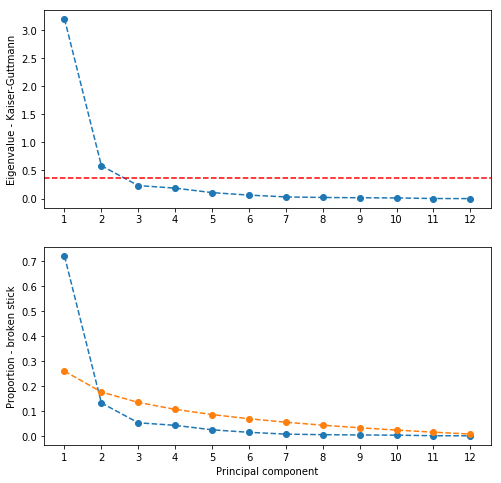

In [75]:
pc = np.arange(len(pca_eigenvalues)) + 1
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(pc, pca_eigenvalues, '--o')
plt.axhline(pca_eigenvalues.mean(), linestyle='--', c='red')
plt.ylabel('Eigenvalue - Kaiser-Guttmann')
plt.xticks(pc)
plt.subplot(2, 1, 2)
plt.plot(pc, 
         eigval_prop, '--o')
plt.plot(pc, 
         broken_stick(len(pca_eigenvalues)), '--o')
plt.ylabel('Proportion - broken stick')
plt.xlabel('Principal component')
plt.xticks(pc);

L'approche *Kaiser-Guttmann* suggère deux composantes et l'approche *broken stick* suggère que seule la première composante est suffisante.

Examinons maintenant les vecteurs propres. D'abord, ils devraient être de longueur unitaire.

In [76]:
np.linalg.norm(x=pca_eigenvectors, axis=1)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

Présentons-les sous forme de tableau.

In [77]:
eigvec_lab = ['eigvec'+ str(i+1) for i in range(len(pca_eigenvectors))]
pd.DataFrame(np.round(pca_eigenvectors, 3), 
             index=eigvec_lab, 
             columns=varechem_coda.columns)

,clrN,clrP,clrK,clrCa,clrMg,clrS,clrAl,clrFe,clrMn,clrZn,clrMo,clrFv
eigvec1,-0.070,-0.112,-0.137,-0.199,-0.135,-0.063,0.496,0.723,-0.324,-0.156,0.034,-0.057
eigvec2,-0.228,0.112,0.206,0.243,0.198,0.054,0.016,0.213,0.086,0.047,-0.853,-0.095
eigvec3,0.417,0.004,-0.156,-0.171,-0.157,-0.149,-0.518,0.438,0.395,-0.193,-0.140,0.228
eigvec4,0.581,-0.045,-0.221,0.079,-0.009,-0.115,0.228,-0.255,-0.425,0.121,-0.341,0.403
eigvec5,-0.069,0.071,-0.039,-0.148,-0.699,-0.003,0.339,-0.128,0.420,0.384,-0.151,0.025
eigvec6,-0.192,0.057,-0.505,0.249,0.080,-0.184,-0.279,0.223,-0.143,0.664,0.095,-0.066
eigvec7,0.254,-0.714,0.122,-0.242,0.306,-0.031,0.093,0.010,0.218,0.334,-0.055,-0.296
eigvec8,0.354,0.409,0.337,-0.296,-0.147,0.100,-0.210,0.067,-0.344,0.249,-0.025,-0.495
eigvec9,-0.155,0.273,-0.348,-0.676,0.382,0.327,0.066,-0.093,0.091,0.077,-0.118,0.174
eigvec10,0.295,0.246,-0.472,0.227,0.140,-0.072,0.275,-0.099,0.290,-0.260,-0.010,-0.562


L'ordre d'importance des vecteurs propres est établi en ordre croissant des valeurs propres associées. Un vecteur propre est une combinaison linéaire des variables (ici, les *clr*). Par exemple, le premier vecteur propre pointe surtout dans la direction du Fe (0,723) et de l'Al (0,496). Le deuxième pointe surtout vers le Mo (-0.853). En transposant les vecteurs propres, on est mieux à même d'apprécier les coordonnées dans l'espace des composantes principales.

In [78]:
pd.DataFrame(np.round(pca_eigenvectors, 3), 
             index=eigvec_lab, 
             columns=varechem_coda.columns).T

,eigvec1,eigvec2,eigvec3,eigvec4,eigvec5,eigvec6,eigvec7,eigvec8,eigvec9,eigvec10,eigvec11,eigvec12
clrN,-0.070,-0.228,0.417,0.581,-0.069,-0.192,0.254,0.354,-0.155,0.295,0.073,-0.289
clrP,-0.112,0.112,0.004,-0.045,0.071,0.057,-0.714,0.409,0.273,0.246,-0.265,-0.289
clrK,-0.137,0.206,-0.156,-0.221,-0.039,-0.505,0.122,0.337,-0.348,-0.472,-0.229,-0.289
clrCa,-0.199,0.243,-0.171,0.079,-0.148,0.249,-0.242,-0.296,-0.676,0.227,0.212,-0.289
clrMg,-0.135,0.198,-0.157,-0.009,-0.699,0.080,0.306,-0.147,0.382,0.140,-0.242,-0.289
clrS,-0.063,0.054,-0.149,-0.115,-0.003,-0.184,-0.031,0.100,0.327,-0.072,0.847,-0.289
clrAl,0.496,0.016,-0.518,0.228,0.339,-0.279,0.093,-0.210,0.066,0.275,-0.156,-0.289
clrFe,0.723,0.213,0.438,-0.255,-0.128,0.223,0.010,0.067,-0.093,-0.099,0.052,-0.289
clrMn,-0.324,0.086,0.395,-0.425,0.420,-0.143,0.218,-0.344,0.091,0.290,-0.107,-0.289
clrZn,-0.156,0.047,-0.193,0.121,0.384,0.664,0.334,0.249,0.077,-0.260,-0.054,-0.289


Les vecteurs (*loadings*) d'un biplot de distance présentant les des deux premières composantes principales prendront les coordonnées des deux premières colonnes. Le vecteur clrAl aura la coordonnée [0,496 ; 0,016], le vecteur de clrFe sera placé à [0,723 ; 0,213] et le vecteur clrMo à [0,034 ; -0,853].

Lançons la fonction `biplot`, créée plus haut pour créer ddes biplots de distance et de corrélation. Il est convenable de magnifier les vecteurs pour favoriser la visualisation. Cette fonction s'attend à ce que les vecteurs propres soient entrés avec les vecteurs propres en colonnes et les variables en lignes, ce qui correspond à la transposée des vecteurs propres sortis de la fonction PCA de scikit-learn.

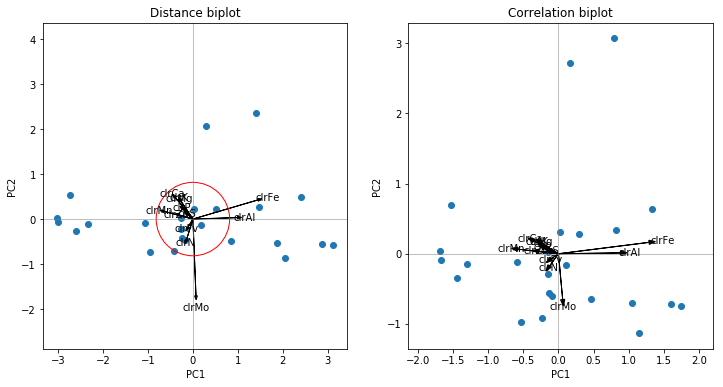

In [79]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
op.biplot(objects=pca_scores,
          eigenvectors=pca_eigenvectors.T * 2,
          eigenvalues=pca_eigenvalues,
          scaling='distance',
          vector_labels=varechem_coda.columns,
          xpc=0, ypc=1)
plt.axis('equal')
plt.gcf().gca().add_artist(plt.Circle((0,0), np.sqrt(2/len(pca_eigenvalues)) * 2, color='r', fill=False)) # compliqué de dessiné un cercle!
plt.title('Distance biplot')
plt.subplot(1, 2, 2)
op.biplot(objects=pca_scores,
          eigenvectors=pca_eigenvectors.T,
          eigenvalues=pca_eigenvalues,
          scaling='correlation',
          vector_labels=varechem_coda.columns,
          xpc=0, ypc=1)
plt.axis('equal')
plt.title('Correlation biplot');

Le biplot de distance (à gauche) inclut un **cercle d'équilibre des contributions**, dont le rayon est égal à $\sqrt{\frac{d}{p}}$ où $d$ est le nombre de dimension de la représentation ($d=2$ dans un biplot à deux composantes) et $p$ est le nombre de variables (égal au nombre de valeurs propres). Les vecteurs plus longs que le rayon de ce cercle contribue aux composantes principales davantage que la moyenne. Puisque nous avons multiplié par deux la longueur des vecteurs propres, nous avons aussi multiplié par deux le rayon de ce cercle.

Le biplot de distance permet de dégager les variables qui explique davantage la variabilité dans notre tableau: les clr du Fe et de l'Al forment en grande partie le premier axe principal, alors que le clr du Mo forme en grande partie le second axe. Le biplot de corrélation montre que les clr du Fe et du Al sont corrélés dans le même sens, mais das le sens contraire du clr du Mn. L'information sur la teneur en Fe et celle de l'Al est en grande partie redondante. Toutefois, le clr du Mo est presque indépendant du clr du Fe, ceux-ci étant à angle presque droit (~90°). Ces relations peuvent être explorées directement.

Text(0.5,0,'clr Mo')

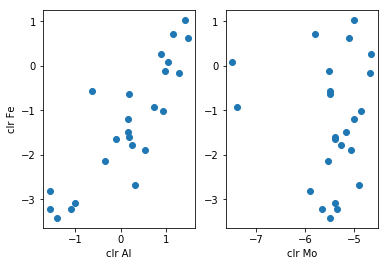

In [80]:
plt.subplot(1, 2, 1)
plt.plot(varechem_coda.clrAl, varechem_coda.clrFe, 'o')
plt.xlabel('clr Al')
plt.ylabel('clr Fe')
plt.subplot(1, 2, 2)
plt.plot(varechem_coda.clrMo, varechem_coda.clrFe, 'o')
plt.xlabel('clr Mo')

Nous avons mentionné que l'ACP est une rotation. Prenons un second exemple pour bien en saisir les tenants et aboutissants. Le tableau de données que nous chargerons provient d'un infographie d'un dauphin, intitullée *Bottlenose Dolphin*, conçu par l'artiste [Tarnyloo](https://www.blendswap.com/blends/view/83681). Les points correspondent à la surface d'un dauphin. J'ai ajouté une colonne `anatomy`, qui indique à quelle partie anatomique le point appartient.

In [81]:
dolphin = pd.read_csv('data/dolphin.csv', delimiter=',', index_col=0)
dolphin.head()

,x,y,z,anatomy
0,0.042584,-0.370563,-0.075628,Head
1,0.055133,-0.398923,-0.086623,Head
2,0.039111,-0.398674,-0.097054,Head
3,0.059653,-0.374704,-0.068028,Head
4,0.072242,-0.379364,-0.059959,Head


Voici en vue isométrique ce en quoi consiste ce nuage de points.

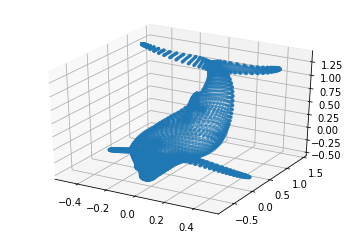

In [82]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=dolphin.x, ys=dolphin.y, zs=dolphin.z, marker='.', alpha=0.5, depthshade=True)

In [83]:
dolphin_coord = dolphin[['x', 'y', 'z']] # tableau d'analyse
pca_dolphin = PCA(n_components=dolphin_coord.shape[1]).fit(dolphin_coord)
pca_scores = pca_dolphin.transform(dolphin_coord)

L'objet `pca` contient l'information nécessaire pour mener notre ACP et présenter notre biplot.

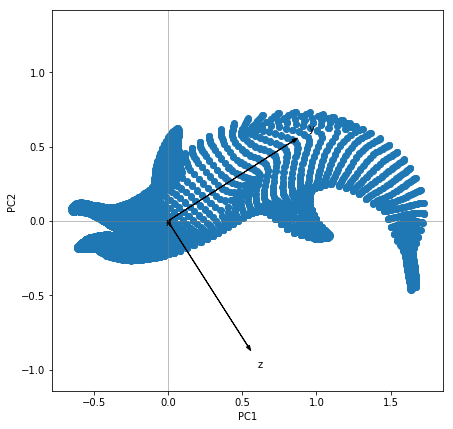

In [84]:
plt.figure(figsize=(7, 7))
op.biplot(objects=pca_scores,
       eigenvectors=pca_dolphin.components_.T,
       eigenvalues=pca_dolphin.explained_variance_,
       scaling='distance',
       vector_labels=dolphin_coord.columns,
       xpc=0, ypc=1)
plt.axis('equal');

La meilleure représentation du dauphin en 3D, selon la variance, est son profil (il est à l'envers, mais la direction des vecteurs propre est arbitraire: ils peuvent être changés de signe sans problème). Remarquons que la représentation des composantes principales montrent un dauphin qui n'est pas distordu. 

<div class="alert alert-block alert-info">**Note**. Une ACP effectue seulement une rotation des points. Les distances euclidiennes entre les points sont maintenues.</div>

<div class="alert alert-block alert-info">**Note**. L'ACP a été conçue pour projetter en un nombre moindre de dimensions des observations dont les distributions sont multinormales (ce n'est évidemment pas le cas du dauphin).</div>

<div class="alert alert-block alert-info">**Note**. Les axes principaux d'une ACP sont des variables aléatoires. Elles peuvent être assujetties à des tests ststistiques, des modèles, du partitionnement de données, etc.</div>

<div class="alert alert-block alert-success">**Excercice**. Effectuez maintenant une ACP avec les données d'iris.</div>

In [85]:
iris.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,species
38,4.4,3.0,1.3,0.2,setosa
64,5.6,2.9,3.6,1.3,versicolor
54,6.5,2.8,4.6,1.5,versicolor
40,5.0,3.5,1.3,0.3,setosa
108,6.7,2.5,5.8,1.8,virginica


#### Analyse de correspondance (AC)

L'analyse de correspondance (ac) est particulièrement appropriée pour traiter des données d'abondance et d'occurence. Tout comme l'analyse en composantes principales, les données apportés vers une AC doivent être dimentionnellement homogène, c'est-à-dire que chaque variable doit être de même métrique: pour des données d'abondance, cela signifie que les décomptes réfèrent tous au même concept: individus, colonies, surfaces occupées, etc. Alors que la distance euclidienne est préservée avec l'ACP, l'AC préserve la distance du $\chi^2$, qui est insensible aux double-zéros.

L'AC produit $min(n,p)-1$ axes principaux orthogonaux qui captent non pas le maximum de variance, mais la proportion de mesures aux carré par rapport à la somme des carrés de la matrice. Le biplot obtenu peut être présenté sous forme de biplot de site (*scaling 1*), où la distance du $\chi^2$ est préservée entre les sites ou biplot d'espèces (*scaling 2*), ou la distance du $\chi^2$ est préservée entre les espèces. L'AC hérite du coup une propriété importate de la distance du $\chi^2$, qui accorde davantage de distance entre un compte de 0 et de 1 qu'entre 1 et 2, et davantage entre 1 et 2 qu'entre 2 et 3.

Par exemple, sur ces trois sites, on a compté un individu A de moins que d'individu B.

In [86]:
abundance_0123 = pd.DataFrame({'A': [0, 1, 9],
                              'B': [1, 2, 10]},
                             index=['Site 1', 'Site 2', 'Site 3']) # , 'Site 4'
abundance_0123

,A,B
Site 1,0,1
Site 2,1,2
Site 3,9,10


Pourtant, la distance du $\chi^2$ est plus élevée entre le site 1 que le site 2 qu'entre le site 2 et le site 3.

In [87]:
pd.DataFrame(squareform(chi_square(abundance_0123)), 
             index=abundance_0123.index, columns=abundance_0123.index)

,Site 1,Site 2,Site 3
Site 1,0.000000,0.672411,0.955532
Site 2,0.672411,0.000000,0.283120
Site 3,0.955532,0.283120,0.000000


La distance du $\chi^2$ donne davantage d'importance aux espèces rares, ce dont une analyse doit tenir compte. Il pourrait être envisageable de retirer d'un tableau des espèces rare, ou bien prétransformer des données d'abondance par une transformation de chord ou de Hellinger (tel que discuté au chapitre 6), puis procéder à une ACP sur ces données ([Legendre et Gallagher, 2001](https://doi.org/10.1007/s004420100716)).

##### Application

Le tableau [`varespec`](https://rdrr.io/rforge/vegan/man/varechem.html) comprend des données de surface de couverture de 44 espèces de plantes en lien avec les données environnementales du tableau `varechem`. Ces données ont été publiées dans [Väre et al. (1995)](http://onlinelibrary.wiley.com/doi/10.2307/3236351/abstract) et exportées du module [`vegan`](https://rdrr.io/rforge/vegan/), langage R.

In [88]:
varespec = pd.read_csv('data/varespec.csv', delimiter=';', index_col='ID')
varespec.sample(5)

,Callvulg,Empenigr,Rhodtome,Vaccmyrt,Vaccviti,Pinusylv,Descflex,Betupube,Vacculig,Diphcomp,...,Cetreric,Cetrisla,Flavniva,Nepharct,Stersp,Peltapht,Icmaeric,Cladcerv,Claddefo,Cladphyl
ID,,,,,,,,,,,,,,,,,,,,,
19,0.00,8.92,0.00,2.42,10.28,0.12,0.02,0.00,0.00,0.00,...,0.00,0.00,0.02,0.00,0.28,0.00,0.0,0.0,0.37,0.0
21,0.00,16.00,4.00,15.00,25.00,0.25,0.50,0.25,0.00,0.00,...,0.00,0.67,0.00,0.00,0.00,0.00,0.0,0.0,0.40,0.0
13,24.13,1.90,0.07,0.22,5.30,0.12,0.00,0.00,0.00,0.07,...,0.18,0.02,0.00,0.00,0.03,0.02,0.0,0.0,0.47,0.0
3,0.03,3.65,0.00,0.00,4.43,0.00,0.00,0.00,1.65,0.50,...,0.05,0.00,0.15,0.15,0.28,0.00,0.0,0.0,0.08,0.0
15,0.67,0.17,0.00,0.35,12.13,0.12,0.00,0.00,0.00,0.00,...,0.15,0.03,0.00,0.00,0.85,0.00,0.0,0.0,1.00,0.0


Pour effectuer l'AC, nous utiliserons le module scikit-bio. Ce module n'est disponible que sur Linux et MacOS: les personnes utilisant Windows devront soit travailler avec un.e colllègue, soit [installer une distribution Linux dans une boîte virtuelle](https://www.youtube.com/results?sp=UBQ%253D&q=installer+ubuntu+virtualbox).

In [89]:
from skbio.stats.ordination import ca

L'AC en *scaling 1* est effectuée sur le tableau des abondances avec les espèces comme colonnes et les sites comme lignes. Les matrices d'abondance transposées indique les sites où chque espèce ont été dénombrées: pour une analyse en *scaling 2*, on effectue une analyse de correspondance sur la matrice d'abondance (ou d'occurence) transposée.

Pour chacune des AC, je spécifie `varespec.sum(axis=1) != 0` pour m'assurer que toutes les lignes contiennent au moins une observation. Ce n,est pas nécessaire dans notre cas, mais je le laisse pour l'exemple.

In [90]:
varespec_ca_species = ca(varespec.loc[varespec.sum(axis=1) != 0, :]) # scaling 1
varespec_ca_sites = ca(varespec.loc[varespec.sum(axis=1) != 0, :].T) # scaling 2

La fonction `biplot` a été conçue pour présenter des ACP. La notion de scaling est donc liée aux valeurs propres. Mais on entend autre chose par scaling dans une AC. Les biplots d'espèces et de sites doivent donc être effectuée sans opérations sur les valeurs propres. On doit spécifier scaling 1, ou rien du tout puisque c'est la valeur par défaut.

La fonction `ca` de scikit-bio sort les vecteurs propres en colonne et les variables en ligne. Nous n'avons pas besoin de les transposer pour le biplot. Afin d'éclaircir la présentation, spécifions `show_arrows=False`.

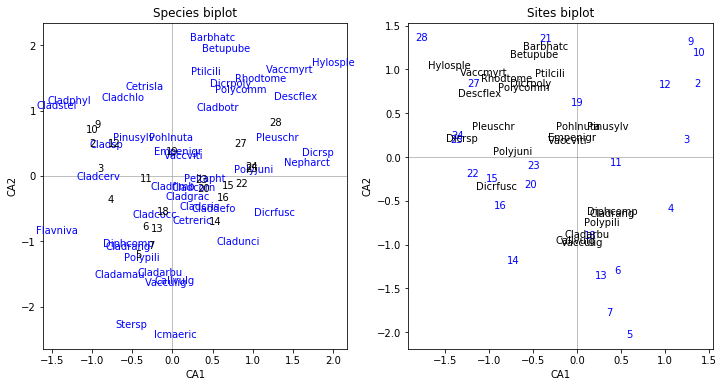

In [91]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
op.biplot(objects=varespec_ca_species.features.as_matrix(),
          object_labels=varespec_ca_species.features.index,
          eigenvectors=varespec_ca_species.samples.as_matrix(),
          vector_labels=varespec_ca_species.samples.index,
          xpc=0, ypc=1, axis_label = 'CA', show_arrows=False)
plt.title('Species biplot')

plt.subplot(1, 2, 2)
op.biplot(objects=varespec_ca_sites.features.as_matrix(),
          object_labels=varespec_ca_sites.features.index,
          eigenvectors=varespec_ca_sites.samples.as_matrix(),
          vector_labels=varespec_ca_sites.samples.index,
          xpc=0, ypc=1, axis_label = 'CA', show_arrows=False)
plt.title('Sites biplot');

Le **biplot des espèces**, à gauche, montre la distribution des sites selon les espèces. Les emplacements des scores (en noir) montrent les contrastes entre sites selon les espèces qui les recouvrent. Les sites 2, 3, 4, 9 10 et 12, par exemple, contrastent les sites 22, 24, 27 et 28 selon le premier axe principal. Par ailleurs, les axes principaux sont formé de plusieurs espèces dont aucune ne domine clairement. 

Le **biplot des sites** montre la distribution des recouvrement d'espèces selon les sites. Par exemple, les espèces Betupube ([*Betula pubescens*](https://fr.wikipedia.org/wiki/Betula_pubescens)) et Barbhatc ([*Barbilophozia hatcheri *](https://en.wikipedia.org/wiki/Marchantiophyta)) se recouvrent en particulier le site 21. Le site 18 est difficile à identifier, car il est couvert par plusieurs noms d'espèces, dans le quadrant en bas à droite. Le site 24 se confond Dicrsp (une espèce de [*Dicranum*](https://en.wikipedia.org/wiki/Dicranum)) qui le recouvre amplement.

In [92]:
ca_eigprop_species = varespec_ca_species.eigvals/varespec_ca_species.eigvals.sum()
ca_eigprop_sites = varespec_ca_sites.eigvals/varespec_ca_sites.eigvals.sum()
print('intertia scaling 1', ca_eigprop_species.values[0:5])
print('intertia scaling 2', ca_eigprop_sites.values[0:5])

intertia scaling 1 [ 0.25198369  0.17127415  0.1125373   0.09382844  0.08526297]
intertia scaling 2 [ 0.25198369  0.17127415  0.1125373   0.09382844  0.08526297]


Le nombre de composantes à retenir peut être évalué par les approches *Kaiser-Guttmann* et *broken-stick*.

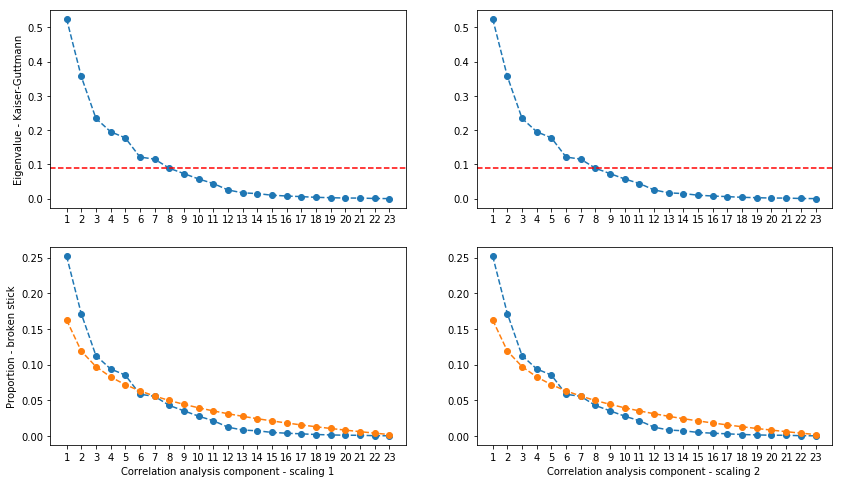

In [93]:
cac = np.arange(len(varespec_ca_species.eigvals)) + 1

plt.figure(figsize=(14, 8))

# Kaiser-Guttmann
## scaling 1
plt.subplot(2, 2, 1)
plt.plot(cac, varespec_ca_species.eigvals, '--o')
plt.axhline(varespec_ca_species.eigvals.mean(), linestyle='--', c='red')
plt.ylabel('Eigenvalue - Kaiser-Guttmann')
plt.xticks(cac)

## scaling 2
plt.subplot(2, 2, 2)
plt.plot(cac, varespec_ca_sites.eigvals, '--o')
plt.axhline(varespec_ca_sites.eigvals.mean(), linestyle='--', c='red')
plt.xticks(cac)

# Broken stick
## scaling 1
plt.subplot(2, 2, 3)
plt.plot(cac, ca_eigprop_species, '--o')
plt.plot(cac, broken_stick(len(varespec_ca_species.eigvals)), '--o')
plt.ylabel('Proportion - broken stick')
plt.xlabel('Correlation analysis component - scaling 1')
plt.xticks(cac);

## scaling 2
plt.subplot(2, 2, 4)
plt.plot(cac, ca_eigprop_sites, '--o')
plt.plot(cac, broken_stick(len(varespec_ca_sites.eigvals)), '--o')
plt.xlabel('Correlation analysis component - scaling 2')
plt.xticks(cac);

Pour les deux scalings, l'approche *Kaiser-Guttmann* propose 7 axes, tandis que l'approche *broken-stick* en propose 5.

Les représentations biplot d'analyse de correspondance peuvent prendre la forme d'un boomerang, en particulier celles qui sont basées sur des données d'occurence. Le tableau suivant initialement de [Chessel et al. (1987)](http://pbil.univ-lyon1.fr/R/pdf/pps047.pdf) et est distribué dans le module R `ade4`.

Text(0.5,1,'Sites biplot')

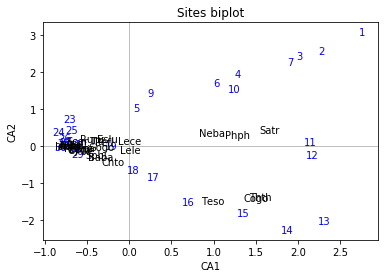

In [94]:
doubs_fish = pd.read_csv('data/doubs_fish.csv', delimiter=',', index_col=0)
doubs_ca_sites = ca(doubs_fish.loc[doubs_fish.sum(axis=1) != 0, :].T)
op.biplot(objects=doubs_ca_sites.features.as_matrix(),
          object_labels=doubs_ca_sites.features.index,
          eigenvectors=doubs_ca_sites.samples.as_matrix(),
          vector_labels=doubs_ca_sites.samples.index,
          xpc=0, ypc=1, axis_label = 'CA', show_arrows=False)
plt.title('Sites biplot')

Les numéros de sites correspondent à la position dans une rivière, 1 étant en amont et 30 en aval. Le premier axe discrimine l'amont et l'aval, tandis que le deuxième montre deux niches en amont. Bien que l'on observe une discontinuité dans le cours d'eau, il y a une continuité dans les abondances. Cet effet peut être corrigé en retirant la tendance de l'analyse de correspondance par une *detrended correspondance analysis*. Pour cela, il faudra passer par le langage R et utiliser la fonction `decorana`, ce qui ne sera pas couvert ici.

L'*analyse des correspondances multiples* (ACM) est utile pour l'ordination des données catégorielles. Le module [*Prince*](https://prince.readthedocs.io) est en mesure d'effectuer des AMC, mais n'est pas couvert dans ce manuel.

<div class="alert alert-block alert-success">**Excercice**. Effectuez et analysez une AC avec les données de recouvrement `varespec`.</div>

In [95]:
varespec.sample(5)

,Callvulg,Empenigr,Rhodtome,Vaccmyrt,Vaccviti,Pinusylv,Descflex,Betupube,Vacculig,Diphcomp,...,Cetreric,Cetrisla,Flavniva,Nepharct,Stersp,Peltapht,Icmaeric,Cladcerv,Claddefo,Cladphyl
ID,,,,,,,,,,,,,,,,,,,,,
3,0.03,3.65,0.00,0.00,4.43,0.00,0.0,0.0,1.65,0.50,...,0.05,0.00,0.15,0.15,0.28,0.00,0.0,0.0,0.08,0.00
13,24.13,1.90,0.07,0.22,5.30,0.12,0.0,0.0,0.00,0.07,...,0.18,0.02,0.00,0.00,0.03,0.02,0.0,0.0,0.47,0.00
18,0.55,11.13,0.00,0.00,17.80,0.07,0.0,0.0,1.60,2.07,...,0.02,0.00,0.12,0.02,0.62,0.02,0.0,0.0,0.25,0.00
11,2.37,0.67,0.00,0.00,12.90,0.80,0.0,0.0,0.00,0.00,...,0.00,0.25,0.00,0.00,0.93,0.25,0.0,0.0,0.00,0.25
6,0.30,5.75,0.00,0.00,10.50,0.10,0.0,0.0,0.00,0.00,...,0.35,0.00,0.08,0.00,0.03,0.00,0.0,0.0,0.28,0.00


#### Positionnement multidimensionnel (PoMd)

Le positionnement multidimensionnel (PoMd), ou [*manifold analysis*](http://scikit-learn.org/stable/modules/manifold.html), se base sur les assiciations entre les objets (mode Q) ou les variables (mode R) pour en réduire les dimensions. Alors que l'analyse en composantes principales conserve la distance euclidienne et que l'analyse de correspondance conserve la distance du $\chi^2$, l'AEM conserve l'association que vous sélectionnerez à votre convenance. L'AEM vise à représenter en un nombre limité de dimensions (souvent 2) la distance (ou dissimilarité) qu'ont les objets (ou des variables) les uns par rapport aux autres dans l'espace multidimensionnel.

Il existe deux types d'AEM. Le **PoMd-métrique** (*metric multidimentional scaling* MMDS, parfois le *metric* est retiré, MDS, et parfois l'on parle de *classic MDS*) vise à représenter fidèlement la distance entre les objets ou les variables. Le PoMd-métrique ne devrait être utilisée que lorsque la métrique n'est ni euclidienne, ni de $\chi^2$ et que l'on désire préserver les distances entre les objets. L'PoMd-métrique aussi appelée *analyse en coordonnées principales* (ACoP ou de l'anglais *PCoA*) .

Le **PoMd-non-métrique** (*nonmetric multidimentional scaling*, NMDS) vise quant à elle à représenter l'ordre des distances entre les objets ou les variables. C'est une approche par rang: le PoMd-non-métrique vise représenter les objets sont plus proches ou plus éloignées les uns des autres plutôt que de représenter leur similarité dans l'espace multidimentionnelle.

L'**IsoMap**, pour *isometric feature mapping*, est une extension du PoMd qui recontruit les distances selon les points retrouvés dans le voisinage. Les isomaps sont en mesure d'applatir des données ayant des formes complexes.

Nous ne traitons pour l'instant que de l'PoMd-métrique. Le module scikit-bio inclut la fonction `pcoa` à cet effet. Les algorithmes de scikit-learn fournissent des fonctions pour les AEM-métriques et non-métriques, pour les Isomap, ainsi que pour de nombreuses autres techniques d'analyse multiple.

##### Application

Utilisons les données d'abondance que nous aonvions au tout début. La matrice d'association de Bray-Curtis sera utilisée. 

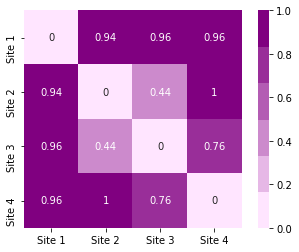

In [96]:
assoc_df = pd.DataFrame(squareform(associations_abund['BrayCurtis']), index=abundance.index, columns=abundance.index)
sns.heatmap(assoc_df, annot=True, square=True, cmap=sns.light_palette("purple"))

Les sites 2 et 3 devraient être plus près l'un et l'autre, puis les sites 3 et 4. Les autres associations sont éloignés d'environ la même distance.

Lançons le calcul de la PoMd-métrique.

In [97]:
from skbio.stats.ordination import pcoa
spe_pcoa = pcoa(squareform(associations_abund['BrayCurtis']))

Les scores des sites se trouvent sous `spe_pcoa.samples`. Les espèces peuvent être projetées dans l'espace de ces scores selon la moyenne pondérée de leur contribution parmi les sites grâce à la fonction [wascores](https://rdrr.io/rforge/vegan/man/wascores.html), placée dans le fichier Python `lib/ordiploy.py`.

In [98]:
wa = op.wascores(x=spe_pcoa.samples.iloc[:, [0, 1]].as_matrix(),
              w=abundance.as_matrix(), expand=True)

Nous pouvons créer nos représentations en 2D. Je rappelle que les textes, dans matplotlib, doivent être affichés un par un. C'est pourquoi nous avons besoin de boucles.

Text(0,0.5,'Dimension 2')

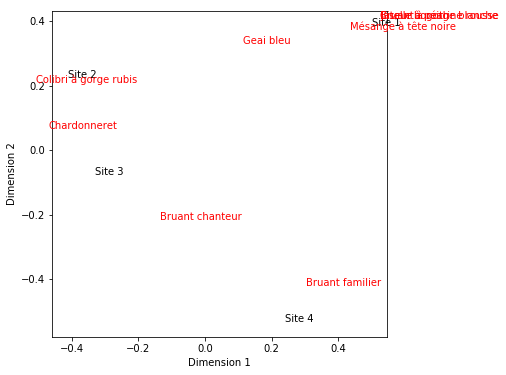

In [99]:
plt.figure(figsize=[6, 6])
plt.plot(spe_pcoa.samples['PC1'], spe_pcoa.samples['PC2'], marker='None', ls='None')
for i in range(len(abundance.index)):
    plt.text(spe_pcoa.samples['PC1'][i], spe_pcoa.samples['PC2'][i], abundance.index[i])
for i in range(wa.shape[0]):
    plt.text(wa[i, 0], wa[i, 1], abundance.columns[i], color='red')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

On observe en effet que les sites 2 et 3 sont les plus près. Les sites 3 et 4sont plus éloignés. Les sites 1, 2 et 4 font à peu près un triangle équilatéral, ce qui correspond à ce à quoi on devrait s'attendre. Les wa-scores permettent de juxtaposer les espèces sur les sites, pour référence. Le colibri n'est prsent que sur le site 2. Le site 1 est populé par des jaseurs et des mésanges, et c'est le seul site où l'on a observé une citelle. On a observé des chardonnerets sur les sites 2 et 3. Sur le site 4, on n'a observé que des bruants, que l'on a aussi observé ailleurs, sauf au site 2.

Plusieurs techniques de PoMd peuvent être calculées avec le module scikit-learn (rubrique [*Manifold learning*](http://scikit-learn.org/stable/modules/manifold.html)). La version PoMd-métrique de scikit-learn (`sklearn.manifold.MDA`, en spécifiant l'argument `metric=True`) fonctionne différemment de la version classique utilisée chez scikit-bio (qui a été présentée plus haut). Le PoMd-métrique de scikit-bio est déterministe ([les coordonnées sont calculées selon les valeurs et vecteurs propres d'une matrice symétrique](https://github.com/biocore/scikit-bio/blob/master/skbio/stats/ordination/_principal_coordinate_analysis.py#L92)), tandis que [le PoMd-métrique de scikit-learn est stochastique]((https://stackoverflow.com/a/38923012)) (le calcul passe par une optimisation itérative selon des centres initialisés au hasard). Le PoMd par scikit-learn ne permet pas de superposer les wa-scores (espèces sur les site). Le PoMd-non-métrique de scikit-learn (`sklearn.manifold.MDA`, en spécifiant l'argument `metric=False`) fonctionne de la même manière, mais la distance est basée sur les rangs. La technique par isomap est aussi disponible sur scikit-learn (`sklearn.manifold.Isomap`).

Les cellules suivantes effectuent les calculs de PoMd-métrique classique (*Deterministic MDS*), de PoMd-métrique stochastique (*Stochastic MDS*), de PoMd-non-métrique (*NMDS*) et d'*isomap* sur un échantillon des coordonnées du dauphin.

In [100]:
from sklearn import manifold
dolphin_sample = dolphin_coord.sample(1000)
dolphin_pcoa = pcoa(squareform(pdist(dolphin_sample, 'euclidean')))
dolphin_mds = manifold.MDS(metric=True).fit(dolphin_sample)
dolphin_nmds = manifold.MDS(metric=False).fit(dolphin_sample)
dolphin_isomap = manifold.Isomap(n_neighbors=10, n_components=2).fit(dolphin_sample)

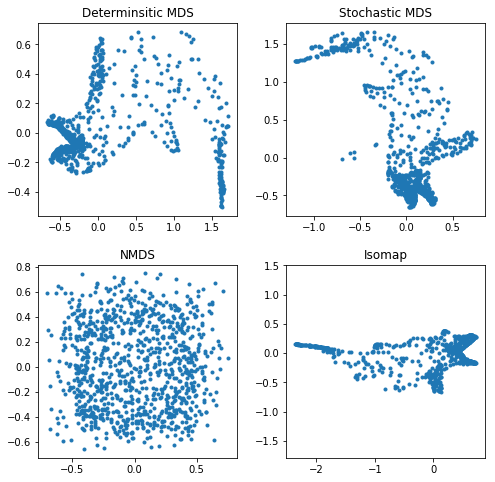

In [101]:
plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
plt.plot(dolphin_pcoa.samples['PC1'], dolphin_pcoa.samples['PC2'], '.')
plt.title('Determinsitic MDS')

plt.subplot(2, 2, 2)
plt.plot(dolphin_mds.embedding_[:,0], dolphin_mds.embedding_[:,1], '.')
plt.title('Stochastic MDS')

plt.subplot(2, 2, 3)
plt.plot(dolphin_nmds.embedding_[:,0], dolphin_nmds.embedding_[:,1], '.')
plt.title('NMDS')

plt.subplot(2, 2, 4)
plt.plot(dolphin_isomap.embedding_[:,0], dolphin_isomap.embedding_[:,1], '.')
plt.title('Isomap')

plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.axis('equal');

<div class="alert alert-block alert-success">**Excercice**. Effectuez et analysez une PoMd-métrique avec les données de `doubs_fish.csv`, qui comprend des données d'abondance de poissons.</div>

In [102]:
doubs_fish.sample(5)

,Cogo,Satr,Phph,Neba,Thth,Teso,Chna,Chto,Lele,Lece,...,Scer,Cyca,Titi,Abbr,Icme,Acce,Ruru,Blbj,Alal,Anan
25,0,0,0,0,0,0,0,0,1,1,...,1,0,0,0,0,1,1,0,3,0
20,0,0,1,2,0,0,2,2,2,3,...,2,1,4,1,0,2,5,2,5,2
15,3,4,4,5,2,4,0,0,3,3,...,0,0,1,0,0,0,0,0,0,0
2,0,5,4,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,5,5,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Conclusion sur l'ordination non contraignante

Lorsque les données sont euclidiennes, l'analyse en composantes principales (ACP) dervait être utilisée. Lorsque la métrique est celle du $\chi^2$, on préférera l'analyse de correspondance (AC). Si la métrique est autre, le positionnement multidimensionel (PoMd) est préférable. Dans ce dernier cas, si l'on recherche une représentation simplifiée de la distance entre les objets ou variables, on utilisera un PoMd-métrique. À l'inverse, si l'on désire une représentation plus fidèle au rang des distances, on préférera l'PoMd-non-métrique.

### Ordination contraignante

Alors que l'ordination non contraignante vous permet de dresser un protrait de vos variables, l'ordination contraignante (ou canonique) permet de tester statistiquement ainsi que de représenter la relation entre plusieurs variables explicatives (par exemple, des conditions environnementales) et une ou plusieurs variables réponses (par exemple, les espèces observées). 

- L'analyse discriminante n'a fondamentalement qu'une seulement variable réponse, et celle-ci doit décrire l'appartenance à une catégorie.
- L'analyse canonique des corrélations sera préférée lorsque les variables sont étalées (comme les variables d'abondance).
- L'analyse de redondance sera préférée lorsque le nombre de variable est plus restreint (variables ionomiques et indicateurs de performance des cultures). Les détails, ainsi que les tenants et aboutissants de ces méthodes, sont présentés dans [Numerical Ecology (Legendre et Legendre, 2012)](https://www.elsevier.com/books/numerical-ecology/legendre/978-0-444-53868-0).

#### Analyse discriminante

Alors que l'analyse en composante principale vise à présenter la perspective (les axes) selon laquelle les points sont les plus éclatées, l'analyse discriminante, le plus souvent utilisé dans sa forme linéaire (ADL) et quadratique (ADQ), vise à présenter la perspective selon laquelle les groupes sont les plus éclatés, les groupes formant la variable contraignante. Ces groupes peuvent être connus (e.g. cultivar, région géographique) ou attribués (exemple: par partitionnement). L'ADL est parfois nommée *analyse canonique de la variance*.

L'AD vise à représenter des différences entre des groupes aux moyens de combinaisons linéaires (ADL) ou quadratique (ADQ) de variables mesurées. Sa représentation sous forme de biplot permet d'apprécier les différences entre les groupes d'identifier les variables qui sont responsables de la discrimination.

<img src="images/ionome-revisited-figure4d.png" alt="" style="width: 600px;"/>
<center>Biplot de distance de l'analyse discriminante des ionomes d'espèces de plantes à fruits cultivées sauvages et domestiquées,  Source: [Parent et al. (2013)](https://doi.org/10.3389/fpls.2013.00039)</center>

L'ADL a été développée par [Fisher (1936)](http://onlinelibrary.wiley.com/doi/10.1111/j.1469-1809.1936.tb02137.x/abstract), qui à titre d'exemple d'application a utilisé un jeu de données de dimensions d'iris collectées par Edgar Anderson, du Jardin botanique du Missouri, sur 150 spécimens d'iris collectés en Gaspésie (Est du Québec), ma région natale. Ce jeu de données est amplement utilisé à titre d'exemple en analyse multivariée.

[Williams (1983)](http://www.jstor.org/stable/1937836) a présenté les tenants et aboutissants de l'ADL en écologie. Tout comme les données passant pas une ACP doivent suivre une distribution multinormale pour être statistiquement valide, les distributions des groupes dans une ADL doivent être multinormales et les variances des points par groupe doivent être homogènes... ce qui est rarement le cas en science. Néanmoins:

> Heureusement, il y a des évidences dans la littérature que certaines d'entre [ces règles] peuvent être transgressées modérément sans de grands changement dans les taux de classification. Cette conclusion dépends, toutefois, de la sévérité des transgressions, et de facteurs structueaux comme la position relative des moyennes des populations et de la nature des dispersions. - [Williams (1983)](http://www.jstor.org/stable/1937836)

L'ADL peut servir autant d'outil d'interprétation que d'outil de classification, c'est à dire de prédire une catégorie selon les variables (chapitre 11). Dans les deux cas, lorsque le nombre de variables approchent le nombre d'observation, les résultats d'une ADL risque d'être difficilement interprétables. Le test approprié pour évaluer l'homodénéité de la covariance est le M-test de Box. Ce test est peu documenté dans la littérature, est rarement utilisé mais a la [réputation](https://en.wikiversity.org/wiki/Box%27s_M) d'être particulièrement sévère. 

Il est rare que des données écologiques aient des dispersions (covariances) homogènes. Contrairement à l'ADL, l'ADQ ne demande pas à ce que les dispersions (covariances) soient homogènes. Néanmoins, l'ADQ ne génère ni de scores, ni de loadings: il s'agit d'un outil pour prédire des catégories (classification), non pas d'un outil d'ordination.

##### Application

Utilisons les données d'iris.

In [103]:
import seaborn as sns
iris = sns.load_dataset("iris")

Testons la multinormalité par groupe. Rappelons-nous que pour considérer la distribution comme multinormale, la p-value de la distortion (`P-value skew`) ainsi que la statistique de Kurtosis (`Z kurtosis`) doivent être égale ou plus élevée que 0.05.

In [104]:
groups = iris.species.unique()
for i in groups:
    data = iris.loc[iris.species == i, :].drop('species', axis=1).as_matrix()
    mt = mardia_test(data)
    print('Group:', i, 'Pval:', mt['P-value skew'], 'Kurtosis:', mt['Z kurtosis'])

Group: setosa Pval: 0.177185884468 Kurtosis: 1.29499223712
Group: versicolor Pval: 0.19444448314 Kurtosis: -0.571866358934
Group: virginica Pval: 0.15705970769 Kurtosis: 0.152614173978


Seul l'espèce versicolore ne passe pas le test de Kurtosis. Voyons maintenant l'homogénéité de la covariance. Pour ce faire, nous aurons besoin de la fonction `box_mtest`, située dans le fichier du même nom dans le dossier `lib`. Pour que les covariances soient considérées comme égales, la p-vaule doit être supérieure à 0.05.

In [105]:
from lib.box_mtest import box_mtest
from sklearn import preprocessing

iris_dim = iris.iloc[:,0:4] # les dimensions des fleurs

box_m_iris = box_mtest(data=iris_dim.as_matrix(), groups=iris.species)
box_m_iris['P-value']

3.352034178317213e-20

On est loin d'un cas où les distributions sont homogènes. Nous allons néanmoins procéder.

In [106]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

iris_dim_sc = preprocessing.scale(iris_dim, axis=0) # standardiser à une moyenne de 0 et une variance de 1
iris_lda = LDA(solver='eigen', n_components=2)
iris_lda.fit(X=iris_dim_sc, y=iris.species)

LinearDiscriminantAnalysis(n_components=2, priors=None, shrinkage=None,
              solver='eigen', store_covariance=False, tol=0.0001)

scikit-learn n'offre pas une sortie complète des valeurs propres. Nous sommes condamnés à présenter le biplot de distance: c'est d'ailleurs la fore courrante des biplots représentant les ADL. Notez que contrairement à l'ACP, les vecteurs propres ne doivent pas être transposés.

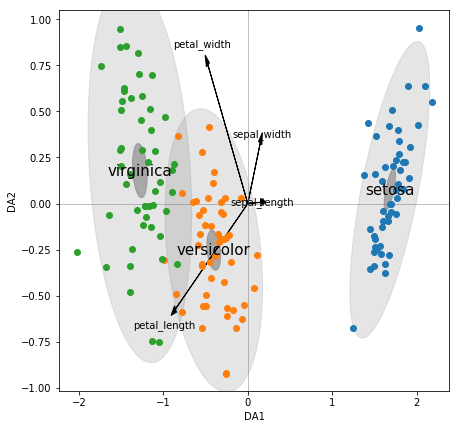

In [107]:
plt.figure(figsize=(7, 7))
op.biplot(objects=iris_lda.transform(iris_dim_sc),
          eigenvectors=iris_lda.scalings_,
          vector_labels=iris_dim.columns,
          axis_label = 'DA',
          group=iris.species,
          plot_ellipses=True)

À la différence de l'ACP, l'ADL maximise la sépatation des groupes. Nous avions noté avec l'ACP que les dimensions des pétales distingaient les groupes. Puisque nous avions justement des informations sur les groupes, nous aurions pu procéder directement à un ADL pour obtenir des conclusions plus directes. Si la longueur des pétales permet de distinguer l'espèce *setosa* des deux autres, la largeur des pétales permet de distinguer *virginica* et *versicolor*, bien que les nuages de points se superposent. De manière bivariée, les régions de confiance des moyennes des scores discriminants (petites ellipses) montrent des différence significatives au seuil 0.05. 

<div class="alert alert-block alert-success">**Excercice**. Si l'on effectuait l'ADL sur notre dauphin, avec la colonne `anatomy` comme  variable de regroupement, qu'obtiendrions-nous? Si l'on consière la nageoire codale (queue) comme faisant partie du corps? Quelles sont les limitations?</div>

POURQUOI LES VECTEURS NE SONT PAS ORTHOGONAUX COMME DANS LA PCA?

#### Analyse de redondance (RDA)

En anglais, on la nomme *redundancy analysis*, souvent abrégée RDA. Elle est utilisée pour résumer les relations linéaires entre des variables réponse et des variables explicatives. La "redondance" se situe dans l'utilisation de deux tableaux de données contenant de l'information concordante. L'analyse de redondance est une manière élégante d'effectuer une régresssion linéaire multiple, où la matrice de valeurs prédites par la régression est assujettie à une analyse en composantes principales. Il est ainsi possible de superposer les scores des variables explicatives à ceux des variables réponse.

Plus précisément, une RDA effectue les étapes suivantes ([Borcard et al. (2011)](http://www.springer.com/us/book/9781441979759)) entre une matrice de variables indépendantes (explicatives) $X$ et une matrice de variables dépendantes (réponse) $Y$.

##### 1. Régression entre $Y$ et $X$
Pour chacune des variables réponse de $Y$ ($y_1$, $y_2$, , $y_j$), effectuer une régression linéaire sur les variables explicatives $X$. 

$$\hat{y}_j = b_j + m_{1, j} \times x_1 + m_{2, j} \times x_2 + ... + m_{i, j} \times x_i$$
    $$\hat{y}_j = y_j + y_{res, j}$$

Pour chaque observation ($n$), nous obtenons une série de valeurs de $\hat{y}_j$ et de $y_{res, j}$. Donc chaque cellule de la matrice $Y$ a ses pendant $\hat{y}$ et $y_{res}$. Nous obtenons ainsi une matrice de prédiction $\hat{Y}$ et une matrice des résidus $Y_{res} = Y - \hat{Y}$.

##### 2. Analyse en composantes principales

Ensuite, on effectue une analyse en composantes principales (ACP) sur la matrice des prédictions $\hat{Y}$. On obtient ainsi ses valeurs et vecteurs propres. Nommons $U$ ses vecteurs propres. Les fonctions de RDA mettent souvent ces veceturs à l'échelle avant de les retourner à l'utilisateur. En ordination écologique, ces vecteurs mis à l'échelle sont souvent appelés les *scores des espèces*, bien qu'il ne s'agisse pas nécessairement d'espèces, mais plus généralement des variables de la matrice dépendante $Y$.

Il est aussi possible d'effectuer une ACP sur $Y_{res}$.

##### 3. Calculer les scores

Les vecteurs propres $U$ sont utilisés pour calculer les *scores des sites*, $Y \times U$, ainsi que les *contraintes de site*  $\hat{Y} \times U$.

##### Application

Nous allons utiliser la fonction `rda` du module scikit-bio. *La version courante de cette fonction ne fonctionne pas. Elle est [en réparation](https://github.com/biocore/scikit-bio/pull/1529). Pour l'utiliser, copier [ma réparation](https://raw.githubusercontent.com/essicolo/scikit-bio/rda-fix/skbio/stats/ordination/_redundancy_analysis.py) et collez-la dans le fichier `anaconda3/lib/python3.6/site-packages/skbio/stats/ordination/_redundancy_analysis.py`*. Puis pour réimporter scikit-bio,lancez:

```
%load_ext autoreload
%autoreload 2
import skbio as sb
```

En ce qui a trait aux données, utilisons les données varespec (matrice Y) et varechem (matrice X).

In [108]:
import skbio as sb
varespec
varechem_coda_soil = pd.concat([varechem[['Baresoil', 'Humdepth', 'pH']], varechem_coda], 
                               axis=1)

In [109]:
rda_sc1 = sb.stats.ordination.rda(x=varechem_coda_soil,
                               y=varespec,
                               scale_Y=False,
                               scaling=1)
rda_sc2 = sb.stats.ordination.rda(x=varechem_coda_soil,
                               y=varespec,
                               scale_Y=False,
                               scaling=2)

Les sorties de cette fonctions sont les suivantes.

| Sortie | Description |
|---|---|
|`rda_.eigvals`|non pas les valeurs propres, mais les **valeurs singulières** de l'ACP (sous forme de décomposition en valuers singilières, DVS) sur $\hat{Y}$, proportionnelles aux valeurs propres|
|`rda_.features`|**scores des espèces** ou des variables dépendantes, soit les vecteurs propres $U$ |
|`rda_.samples`|**scores des sites** ou des observations, $Y \times U$|
|`rda_.sample_constraints`|**scores des contraintes** de site,  $Y_{res} \times U$|
|`rda_.biplot_scores`|**scores d'environnement**, ou des variables dépendantes (corrélation entre les varriables dépendantes et la matrice unitaire à gauche de la DVS sur $\hat{Y}$)|

La fonction maison `triplot` du fichier ordiplot.py, dont nous avons déjà créé l'instance `op`, permet de créer un triplot de base. La mise à l'échelle (*scaling*) est définie dans la fonction `rda`. Les scores des sites peuvent ou non être représentés sous forme de scores pondérés via la fonction `wascore` présentée plus haut. La représentation des wascores est réputée plus robuste (moins susceptible d'être bruitée), mais leur interprétation porte à confusion (). Puisque la fonction `triplot` demande des tableaux et non des matrices, on transformerait les scores de sites ainsi pour en obtenir les scores pondérés.

In [110]:
wa_sites = pd.DataFrame(op.wascores(x=rda_sc1.samples.iloc[:, [0, 1]].as_matrix(), w=varespec.as_matrix()))

En présentant sur un même graphique les scores des objets (observations ou sites), des variables dépendantes (espèces) et des variables indépendantes (environnement), on cré un *triplot*. Tant pour les triplots de distance que ceux de corrélation, la projection des sites par rapport aux variables quantitatives dépendantes (Y) et indépendantes (X) représente la position du site par rapport aux variables (si `arrow_scale=1`). Pour les variables qualitatives (dummifiées), leur position peut être interprétée directement par catégorie, ou bien, pour la variable qualitative, au centroïde des catégories.

À VÉRIFIER: pour scling 1, Borcard parle de la *position* du site par rapport, alors qu'en scaling 2, il parle de la *valeur* du site... Est-ce la même chose?

**Triplot de distance (scaling 1)**. Les angles entre les variables indépendantes (X) représentent leur corrélation (non pas les variables dépendantes Y). 

**Triplot de corrélation (sacling 2)**. Les angles entre les variables représentent leurs corrélation, que les variables soient dépendantes, indépendantes ou entre dépendantes et indépendantes. Les distances entre les objets sur le triplot ne sont pas des approximation de leur distance euclidienne.

Les variables environnementales étant difficile à interprété sans qu'elles sont magnifiées (`arrow_scale=1`), nous spécifieront `arrow_scale=0`, ce qui laissera la fonction triplot ajuster automatiquement leur magnification.

Text(0.5,1,'Triplot, scaling 2')

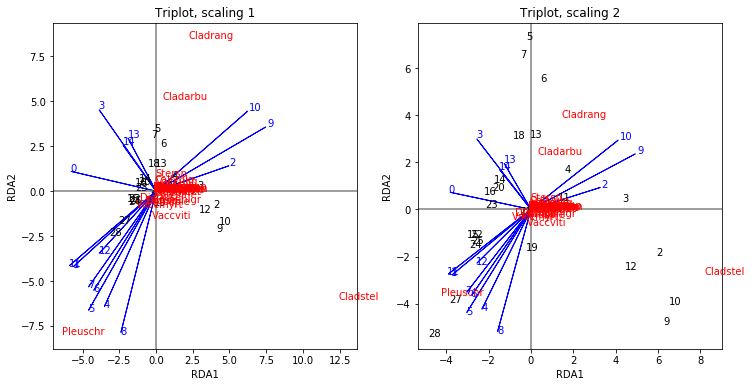

In [111]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
op.triplot(objects=rda_sc1.samples, 
           species=rda_sc1.features, 
           eigenvectors=rda_sc1.biplot_scores,
           arrow_scale=0,
           axis_label='RDA',
           arrow_head_width=0)
plt.title('Triplot, scaling 1')
plt.subplot(1, 2, 2)
op.triplot(objects=rda_sc2.samples, 
           species=rda_sc2.features, 
           eigenvectors=rda_sc2.biplot_scores,
           arrow_scale=0,
           axis_label='RDA',
           arrow_head_width=0)
plt.title('Triplot, scaling 2')

Les triplots montrent que les variables ont toutes un rôle important sur la dispersion des sites autours des axeds principaux. Le premier axe principal est composé de manière plus marquée par le clr de l'Al et celui du Fe. Le deuxième axe principal est composé de manière plus marquée par le clr du S, du P et du K. Le triplot de corrélation ne présente pas de tendance appréciable pour la plupart des espèces, qui ne possèdent pas de niche particulière. Toutefois, l'espèce Cladstel, présente surtout dans les sites 9 et 10, est liée à de basses teneurs en N et à de faibles valeurs de Baresoil (sol nu). L'espèce Pleuschr est liée à des sols où l'on retrouve une grande épaisseur d'humus, ainsi que des teneurs élevées en nutriment K, P, S, Ca, Mg et Zn. Elle semble apprécier les sols à bas pH, mais à faible teneur en Fe et Al. La teneur en N lui semble plus indifférente.

La fonction rda a une sortie `proportion_explained` qui ne correspond pas à ce que l'on devrait s'attendre. La proportion expliquée devrait être calculée selon les valeurs propres, non pas les valeurs singulières de la DVS ($s$). Pour les récupérer, nous appliquerons l'équation suivante.

$$eigenvalues = \frac{s^2}{n_{samples}-1}$$

La proportion expliquée est la proporiton des valeurs propores sur leur somme totale, présentée sur graphique sous forme cumulée.

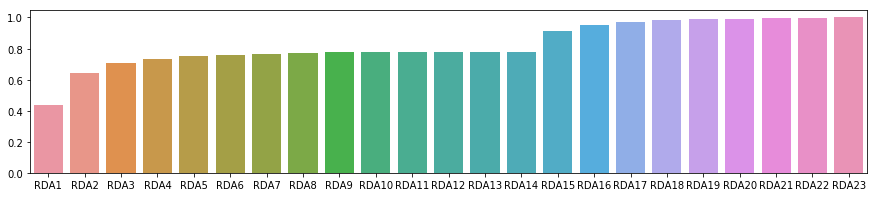

In [112]:
rda_eigenvalues = (rda_sc1.eigvals ** 2) / (varechem.shape[0] - 1)
prop_explained = rda_eigenvalues / rda_eigenvalues.sum()

plt.figure(figsize=(15, 3))
sns.barplot(x=rda_sc1.proportion_explained.index, y=prop_explained.cumsum())

Les deux premiers axes principaux cumulent 67% de la variance. À partir de RDA15, il s'agit des axes de $Y_{res}$, donc de l'explication de la variance par l'erreur.

Étant une collection de régressions, une RDA est en mesure d'effectuer des tests statistiques sur les coefficients de la régression. Malheureusement, la fonction rda de scikit-bio n'effectue pas en ce moment ces tests statistiques. Si vous désirez obtenir ces test, vous devrez en ce moment passer par le langage R:

```
library(vegan) # charger le module pour la rda
data(varespec) # charger les données
data(varechem)
rda_ = rda(varespec~., varechem, scale=FALSE) # rda
anova(rda_, by="term") # test statistique sur les coefficients
```

Dans le cas des matrices d'abondance (ce n'est pas le cas de varespec, constituée de données de recouvrement), il est préférable avec les RDA de les transformer préalablement avec la transformation compositionnelle, de chord ou de Hellinger (chapitre 6). Une autre option est d'effectuer une RDA sur des matrices d'association en passant par une analyse en coordonnées principales ([Legendre et Anderson, 1999](http://www.jstor.org/stable/2657192 )). Enfin, les données d'abondance est d'utiliser une analyse canonique des corrélations.

#### Analyse canonique des correspondances (ACC)

L'analyse canonique des correspondances (*Canonical correspondance analysis*), ACC, a été à l'origine conçue pour étudier les liens entre des variables environnementales et l'abondance (décompte) ou l'occurence (présence-absence) d'espèces ([ter Braak, 1986](https://www.ohio.edu/plantbio/staff/mccarthy/multivariate/terBraak1986.pdf)). L'ACC est à la RDA ce que la CA est à l'ACP. Alors que la RDA préserve les distance euclidiennes entre variables dépendantes et indpendantes, l'ACC préserve les distances du $\chi^2$. Tout comme l'AC, elle hérite du coup une propriété importate de la distance du $\chi^2$: il y a davantage davantage d'importance aux espèces rares.

L'analyse des correspondances canoniques est souvent utilisée dans la littérature, mais dans bien des cas une RDA sur des données d'abondance transformées donnera des résultats davantage intérprétables ([Legendre et Gallagher, 2001](https://doi.org/10.1007/s004420100716)).

##### Application

Cet exemple d'application concerne des données d'abondance. Nous allons conséquemment utiliser une CCA avec la fonction `cca`. Puisque les RDA sont menées de la même manière avec scikit-bio, mais avec la fonction `rda`, nous ne les couvrirons pas ici.

Les tableaux [`doubs_fish` et `doubs_env`](https://rdrr.io/cran/ade4/man/doubs.html) comprennent respectivement des données d'abondance d'espèces de poissons et dans différents environnements de la rivière Doubs (Europe) publiées dans [Verneaux. (1973)](https://www.worldcat.org/title/cours-deau-de-franche-comte-massif-du-jura-recherches-ecologiques-sur-le-reseau-hydrographique-du-doubs-essai-de-biotypologie/oclc/496763306) et exportées du module [`ade4`](https://rdrr.io/rforge/ade4/), langage R.

In [113]:
doubs_env = pd.read_csv('data/doubs_env.csv', delimiter=',', index_col=0)
doubs_fish = pd.read_csv('data/doubs_fish.csv', delimiter=',', index_col=0)

Sur le site no 8, aucun poisson n'a pas été observé. Les observations ne comprenant que des zéro doivent être préalablement retirées.

In [114]:
doubs_env = doubs_env.loc[doubs_fish.sum(axis=1)!=0, :]
doubs_fish = doubs_fish.loc[doubs_fish.sum(axis=1)!=0, :]

De la même manière qu'avec la fonction rda de scikit bio, nous utilisons cca pour l'ACC.

In [115]:
cca_sc1 = sb.stats.ordination.cca(y=doubs_fish, x=doubs_env, scaling=1)
cca_sc2 = sb.stats.ordination.cca(y=doubs_fish, x=doubs_env, scaling=2)

À titre comparatif, menons une RDA sur des données d'abondance transformée avec la technique de chord.

In [116]:
%load_ext autoreload
%autoreload 2
import skbio as sb

In [117]:
doubs_fish_tr = doubs_fish.apply(lambda x: x/np.sqrt((x**2).sum()), axis=1) # bug dans rda

rda_sc1_doubs = sb.stats.ordination.rda(y=doubs_fish_tr, x=doubs_env, scaling=1)
rda_sc2_doubs = sb.stats.ordination.rda(y=doubs_fish_tr, x=doubs_env, scaling=2)

Les quatre triplots.

Text(0.5,1,'RDA triplot, scaling 2')

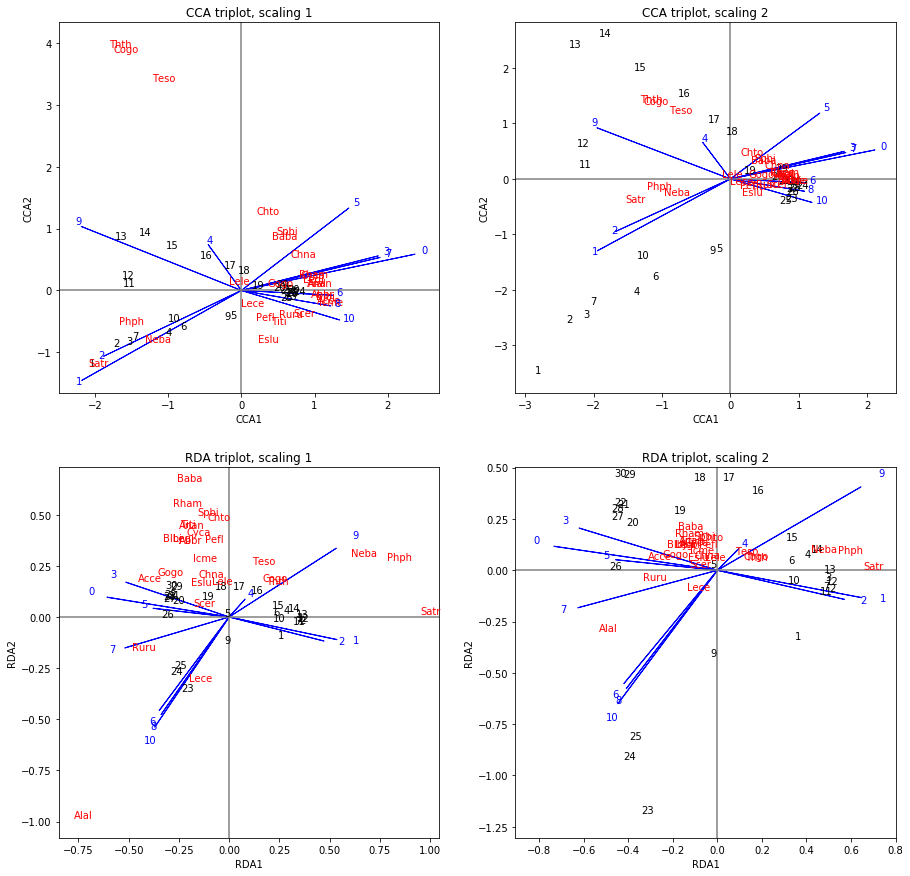

In [118]:
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
op.triplot(objects=cca_sc1.samples, species=cca_sc1.features, eigenvectors=cca_sc1.biplot_scores,
           arrow_scale=0, axis_label='CCA', arrow_head_width=0)
plt.title('CCA triplot, scaling 1')
plt.subplot(2, 2, 2)
op.triplot(objects=cca_sc2.samples, species=cca_sc2.features, eigenvectors=cca_sc2.biplot_scores,
           arrow_scale=0, axis_label='CCA', arrow_head_width=0)
plt.title('CCA triplot, scaling 2')
plt.subplot(2, 2, 3)
op.triplot(objects=rda_sc1_doubs.samples, species=rda_sc1_doubs.features, eigenvectors=rda_sc1_doubs.biplot_scores,
           arrow_scale=0, axis_label='RDA', arrow_head_width=0)
plt.title('RDA triplot, scaling 1')
plt.subplot(2, 2, 4)
op.triplot(objects=rda_sc2_doubs.samples, species=rda_sc2_doubs.features, eigenvectors=rda_sc2_doubs.biplot_scores,
           arrow_scale=0, axis_label='RDA', arrow_head_width=0)
plt.title('RDA triplot, scaling 2')

## Résumé

Tableau quelle analyse sélectionner? Faire un flow chart.